# LIBRERIAS

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet18
from ultralytics import YOLO
from torchvision import models

import cv2
import pandas as pd
import numpy as np
from PIL import Image
import os
from datetime import datetime


import glob
from tqdm import tqdm
import time

import matplotlib.pyplot as plt
import matplotlib.patches as patches




# PROCESS IMAGES 

In [2]:
# --- Parameters --- #
BEHAVIOR_CLASSES = ['Walking', 'Standing', 'Feeding head up', 'Feeding head down', 'Licking', 'Drinking', 'Lying']
IMAGE_SIZE = (224, 224)
LYING_CLASS_ID = 6

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# CARGAR LOS MODELOS SIN PROCESAMIENTO DE LA FUNCION 

In [3]:
YOLO_MODEL_PATH ="yolov8_fold_3.pt"
BEHAVIOR_MODEL_PATH = "best_cow_behavior_classifier.pth"

## YOLO MODEL (BOUNDING BOXES)

In [4]:
# --- Load YOLOv8 model for cow identification --- #
def load_yolo_model(model_path):
    return YOLO(model_path)

## RESENET MODEL (BEHAVIOR IDENTIFICATION)

In [5]:
# --- Load ResNet18 model for behavior classification --- #
def load_behavior_model(model_path, num_classes):
    model = resnet18(weights='IMAGENET1K_V1')
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

## LYING AND NON LYING POSITIONS

In [6]:
NUM_CLASSES = 16  
def load_efficientnet_b0(path):
    model = models.efficientnet_b0(pretrained=False)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
    state_dict = torch.load(path, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    model.load_state_dict(state_dict)
    model = model.to('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    return model

## TRANSFORMERS 

In [7]:
# --- Define image transformation for behavior classification --- #
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

## LOAD MODEL

In [8]:
id_model_lying = load_efficientnet_b0('lyingModel_3.pt')
id_model_not_lying = load_efficientnet_b0('nonLyingModel_3.pt')
yolo_model = load_yolo_model(YOLO_MODEL_PATH)
behavior_model = load_behavior_model(BEHAVIOR_MODEL_PATH, num_classes=len(BEHAVIOR_CLASSES))

/home/exouser/.conda/envs/mariacows_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/exouser/.conda/envs/mariacows_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## PROCESAMIENTO DE LA IMAGEN

In [9]:
def process_image(img_path, yolo_model, behavior_model, id_model_lying, id_model_not_lying, threshold=0.4):

    # Cargar imagen
    img_pil = Image.open(img_path).convert("RGB")
    yolo_results = yolo_model(img_path)
    boxes = yolo_results[0].boxes

    data = []
    for box in boxes:
        x1, y1, x2, y2 = box.xyxy[0].tolist()
        conf = box.conf[0].item()
        cls = int(box.cls[0].item())

        cropped = img_pil.crop((x1, y1, x2, y2))
        tensor = transform(cropped).unsqueeze(0).to(device)

        with torch.no_grad():
            behavior_logits = behavior_model(tensor)
            behavior_probs = torch.nn.functional.softmax(behavior_logits, dim=1)
            behavior_pred = torch.argmax(behavior_probs, dim=1).item()

        if behavior_pred == LYING_CLASS_ID:
            identity_logits = id_model_lying(tensor)
        else:
            identity_logits = id_model_not_lying(tensor)

        identity_probs = torch.nn.functional.softmax(identity_logits, dim=1)
        identity_pred = torch.argmax(identity_probs, dim=1).item()
        identity_conf = identity_probs[0, identity_pred].item()

        cow_id = identity_pred if identity_conf >= threshold else -1

        data.append({
            "detection_conf": conf,
            "behavior_id": behavior_pred,
            "cow_id": cow_id,
            "cow_confidence": identity_conf,
            "bbox": [x1, y1, x2, y2]
        })

    df = pd.DataFrame(data)
    
    if df.empty or 'cow_id' not in df.columns:
        return pd.DataFrame(),0,[]

    # Guardar vacas perdidas
    df_lost = df[df['cow_id'] == -1]
    cow_id_loss = len(df_lost)
    behavior_lost = df_lost['behavior_id'].tolist()

    return df, cow_id_loss, behavior_lost


# EXTRACCION DE LAS IMAGENES DE LOS VIDEOS CADA 5 SEGUNDOS

In [10]:

def extract_frames_every_n_seconds(video_path, output_folder, seconds=3):
    """
    Extracts full-frame images every `n` seconds from a multi-camera video.

    Parameters:
        video_path (str): Path to the .mp4 video file.
        output_folder (str): Directory where the extracted images will be saved.
        seconds (int): Interval (in seconds) between each extracted frame.
    """
    os.makedirs(output_folder, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)

    if fps == 0:
        print("⚠️ Unable to read video or FPS is zero.")
        return

    frame_interval = int(fps * seconds)

    frame_count = 0
    saved_index = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_interval == 0:
            frame_filename = os.path.join(output_folder, f"frame_{saved_index:05d}.jpg")
            cv2.imwrite(frame_filename, frame)
            saved_index += 1

        frame_count += 1

    cap.release()
    print(f"Extraction complete. {saved_index} frames saved in '{output_folder}'.")



# FUNCION INTELIGENTE QUE HACE EL FILTRO 

In [19]:

def smart_filter_detections(df, iou_threshold=0.7, dist_threshold=60):
    """
    Filters and consolidates cow detections from a single frame.

    Handles:
    - Deduplication: keeps only one detection per cow_id based on confidence.
    - Backfilling: reassigns cow_id = -1 detections by comparing spatial similarity.

    Parameters:
        df (pd.DataFrame): Output from process_image(). Must contain:
            - 'cow_id'
            - 'behavior_id'
            - 'cow_confidence'
            - 'bbox' (list of [x1, y1, x2, y2])
        iou_threshold (float): Threshold for intersection-over-union to consider two bboxes as overlapping.
        dist_threshold (float): Max center distance to consider two detections as same cow.

    Returns:
        pd.DataFrame: Filtered detections with one per cow_id, with new columns:
            - 'was_reassigned' (bool)
            - 'source' (str)
    """

    def bbox_center(b):
        x1, y1, x2, y2 = b
        return ((x1 + x2) / 2, (y1 + y2) / 2)

    def bbox_area(b):
        x1, y1, x2, y2 = b
        return abs((x2 - x1) * (y2 - y1))

    def bbox_iou(boxA, boxB):
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])

        interArea = max(0, xB - xA) * max(0, yB - yA)
        if interArea == 0:
            return 0.0

        boxAArea = bbox_area(boxA)
        boxBArea = bbox_area(boxB)
        return interArea / float(boxAArea + boxBArea - interArea)

    def center_distance(b1, b2):
        c1 = bbox_center(b1)
        c2 = bbox_center(b2)
        return np.linalg.norm(np.array(c1) - np.array(c2))

    df = df.copy()
    df['was_reassigned'] = False
    df['source'] = 'direct'

    # Separate detections
    known = df[df['cow_id'] != -1].copy()
    unknown = df[df['cow_id'] == -1].copy()

    # Deduplicate known cows: keep the highest confidence detection per cow_id
    known = known.sort_values(by='cow_confidence', ascending=False)
    known = known.drop_duplicates(subset='cow_id', keep='first')

    reassigned = []

    for i, unk in unknown.iterrows():
        best_match = None
        best_score = -1

        for j, known_row in known.iterrows():
            iou = bbox_iou(unk['bbox'], known_row['bbox'])
            dist = center_distance(unk['bbox'], known_row['bbox'])

            if iou >= iou_threshold or dist <= dist_threshold:
                score = known_row['cow_confidence']
                if score > best_score:
                    best_score = score
                    best_match = known_row

        if best_match is not None:
            new_row = unk.copy()
            new_row['cow_id'] = best_match['cow_id']
            new_row['was_reassigned'] = True
            new_row['source'] = 'reassigned'
            reassigned.append(new_row)
        else:
            unk['source'] = 'unknown'
            reassigned.append(unk)

    # Combine results
    result = pd.concat([known, pd.DataFrame(reassigned)], ignore_index=True)
    result = result.drop_duplicates(subset='cow_id', keep='first')

    return result


# PROCESAMIENTO DE LAS CARPETAS

In [23]:
def process_folder(folder_path, yolo_model, behavior_model, id_model_lying, id_model_not_lying, threshold=0.6):
    """
    Processes all images in a given folder and returns a unified, filtered DataFrame.

    Parameters:
        folder_path (str): Path to the folder containing images to process.
        yolo_model: Trained YOLO model for detection.
        behavior_model: Model to classify cow behavior.
        id_model_lying: ID model for lying cows.
        id_model_not_lying: ID model for non-lying cows.
        threshold (float): Minimum confidence to assign a cow ID.

    Returns:
        pd.DataFrame: Clean DataFrame with columns ['cow_id', 'behavior_id', 'date', 'image', 'was_reassigned', 'source'].
        int: Number of cows that remained unassigned (cow_id = -1) after filtering.
    """
    all_rows = []
    image_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".jpg")])

    # Extract date from folder name (expected format: MMDD)
    date_label = os.path.basename(folder_path)

    for index, img_name in enumerate(tqdm(image_files, desc=f"Processing {folder_path}")):
        img_path = os.path.join(folder_path, img_name)
        df_raw, _, _ = process_image(img_path, yolo_model, behavior_model, id_model_lying, id_model_not_lying, threshold)

        if not df_raw.empty:
            #print(" df_raw columns:", df_raw.columns.tolist())
            #print(df_raw[['cow_id', 'behavior_id', 'cow_confidence', 'bbox']])
            df_filtered = smart_filter_detections(df_raw)
            df_filtered['date'] = date_label
            df_filtered['image'] = index + 1  # Frame number or order of image
            all_rows.append(df_filtered)

    if all_rows:
        final_df = pd.concat(all_rows, ignore_index=True)

        # Count lost cows (cow_id = -1)
        lost_count = final_df[final_df['cow_id'] == -1].shape[0]
        total_before = final_df.shape[0]
        print(f" Vacas no reasignadas (cow_id = -1): {lost_count}")
        print(f" Porcentaje perdido: {(lost_count / total_before):.2%}")

        # Remove cow_id = -1 from final output
        final_df = final_df[final_df['cow_id'] != -1]

        return final_df[['cow_id', 'behavior_id', 'date', 'image']], lost_count
    else:
        return pd.DataFrame(columns=['cow_id', 'behavior_id', 'date', 'image'])



# MANDAR A LLAMAR MIS FUNCIONES

## PROCESAMIENTO DE VIDEOS

In [69]:
extract_frames_every_n_seconds(
    video_path="0804.mp4",
    output_folder='/home/exouser/Downloads/0804',
    seconds=3
)


Extraction complete. 560 frames saved in '/home/exouser/Downloads/0804'.


## CARPETA DE IMAGENES

In [70]:
df_final, loss_ima = process_folder(
    folder_path='/home/exouser/Downloads/0804',
    yolo_model=yolo_model,
    behavior_model=behavior_model,
    id_model_lying=id_model_lying,
    id_model_not_lying=id_model_not_lying,
    threshold=0.6
)


Processing /home/exouser/Downloads/0804:   0%|          | 0/560 [00:00<?, ?it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00000.jpg: 416x640 6 cows, 9.9ms
Speed: 1.7ms preprocess, 9.9ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   0%|          | 1/560 [00:00<02:00,  4.65it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00001.jpg: 416x640 10 cows, 9.5ms
Speed: 1.7ms preprocess, 9.5ms inference, 4.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   0%|          | 2/560 [00:00<02:01,  4.59it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00002.jpg: 416x640 13 cows, 9.7ms
Speed: 1.7ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   1%|          | 3/560 [00:00<02:16,  4.08it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00003.jpg: 416x640 8 cows, 9.7ms
Speed: 1.7ms preprocess, 9.7ms inference, 4.1ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   1%|          | 4/560 [00:00<02:05,  4.44it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00004.jpg: 416x640 11 cows, 9.8ms
Speed: 1.6ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   1%|          | 5/560 [00:01<02:08,  4.30it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00005.jpg: 416x640 10 cows, 9.5ms
Speed: 1.6ms preprocess, 9.5ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   1%|          | 6/560 [00:01<02:06,  4.39it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00006.jpg: 416x640 12 cows, 9.8ms
Speed: 1.7ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   1%|▏         | 7/560 [00:01<02:12,  4.17it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00007.jpg: 416x640 10 cows, 9.7ms
Speed: 1.7ms preprocess, 9.7ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   1%|▏         | 8/560 [00:01<02:08,  4.29it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00008.jpg: 416x640 10 cows, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   2%|▏         | 9/560 [00:02<02:08,  4.30it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00009.jpg: 416x640 13 cows, 9.7ms
Speed: 1.8ms preprocess, 9.7ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   2%|▏         | 10/560 [00:02<02:13,  4.13it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00010.jpg: 416x640 12 cows, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   2%|▏         | 11/560 [00:02<02:17,  3.99it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00011.jpg: 416x640 10 cows, 9.4ms
Speed: 1.6ms preprocess, 9.4ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   2%|▏         | 12/560 [00:02<02:12,  4.15it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00012.jpg: 416x640 9 cows, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   2%|▏         | 13/560 [00:03<02:07,  4.27it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00013.jpg: 416x640 12 cows, 9.6ms
Speed: 1.7ms preprocess, 9.6ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   2%|▎         | 14/560 [00:03<02:10,  4.20it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00014.jpg: 416x640 12 cows, 9.6ms
Speed: 1.6ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   3%|▎         | 15/560 [00:03<02:13,  4.07it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00015.jpg: 416x640 10 cows, 9.6ms
Speed: 1.8ms preprocess, 9.6ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   3%|▎         | 16/560 [00:03<02:09,  4.20it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00016.jpg: 416x640 12 cows, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   3%|▎         | 17/560 [00:04<02:12,  4.09it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00017.jpg: 416x640 8 cows, 9.5ms
Speed: 1.7ms preprocess, 9.5ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   3%|▎         | 18/560 [00:04<02:03,  4.38it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00018.jpg: 416x640 11 cows, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   3%|▎         | 19/560 [00:04<02:07,  4.24it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00019.jpg: 416x640 8 cows, 9.4ms
Speed: 1.7ms preprocess, 9.4ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   4%|▎         | 20/560 [00:04<02:00,  4.49it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00020.jpg: 416x640 8 cows, 9.6ms
Speed: 1.6ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   4%|▍         | 21/560 [00:04<01:56,  4.62it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00021.jpg: 416x640 9 cows, 9.7ms
Speed: 1.7ms preprocess, 9.7ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   4%|▍         | 22/560 [00:05<01:54,  4.69it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00022.jpg: 416x640 7 cows, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   4%|▍         | 23/560 [00:05<01:51,  4.82it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00023.jpg: 416x640 6 cows, 9.6ms
Speed: 1.7ms preprocess, 9.6ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   4%|▍         | 24/560 [00:05<01:44,  5.15it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00024.jpg: 416x640 6 cows, 9.6ms
Speed: 1.6ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   4%|▍         | 25/560 [00:05<01:40,  5.31it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00025.jpg: 416x640 7 cows, 9.7ms
Speed: 1.7ms preprocess, 9.7ms inference, 4.1ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   5%|▍         | 26/560 [00:05<01:38,  5.40it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00026.jpg: 416x640 4 cows, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   5%|▍         | 27/560 [00:05<01:33,  5.72it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00027.jpg: 416x640 5 cows, 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 4.1ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   5%|▌         | 28/560 [00:06<01:29,  5.96it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00028.jpg: 416x640 6 cows, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   5%|▌         | 29/560 [00:06<01:30,  5.90it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00029.jpg: 416x640 6 cows, 9.5ms
Speed: 1.6ms preprocess, 9.5ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   5%|▌         | 30/560 [00:06<01:28,  5.97it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00030.jpg: 416x640 6 cows, 9.6ms
Speed: 1.6ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   6%|▌         | 31/560 [00:06<01:30,  5.84it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00031.jpg: 416x640 5 cows, 9.5ms
Speed: 1.6ms preprocess, 9.5ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   6%|▌         | 32/560 [00:06<01:26,  6.09it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00032.jpg: 416x640 6 cows, 9.8ms
Speed: 1.6ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   6%|▌         | 33/560 [00:06<01:28,  5.97it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00033.jpg: 416x640 10 cows, 9.7ms
Speed: 1.8ms preprocess, 9.7ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   6%|▌         | 34/560 [00:07<01:36,  5.46it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00034.jpg: 416x640 5 cows, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   6%|▋         | 35/560 [00:07<01:33,  5.63it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00035.jpg: 416x640 7 cows, 9.6ms
Speed: 1.7ms preprocess, 9.6ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   6%|▋         | 36/560 [00:07<01:33,  5.63it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00036.jpg: 416x640 7 cows, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   7%|▋         | 37/560 [00:07<01:34,  5.53it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00037.jpg: 416x640 6 cows, 9.6ms
Speed: 1.7ms preprocess, 9.6ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   7%|▋         | 38/560 [00:07<01:31,  5.69it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00038.jpg: 416x640 6 cows, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   7%|▋         | 39/560 [00:08<01:32,  5.65it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00039.jpg: 416x640 7 cows, 9.7ms
Speed: 1.8ms preprocess, 9.7ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   7%|▋         | 40/560 [00:08<01:32,  5.64it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00040.jpg: 416x640 7 cows, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   7%|▋         | 41/560 [00:08<01:33,  5.53it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00041.jpg: 416x640 7 cows, 9.7ms
Speed: 1.7ms preprocess, 9.7ms inference, 4.1ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   8%|▊         | 42/560 [00:08<01:33,  5.55it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00042.jpg: 416x640 6 cows, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   8%|▊         | 43/560 [00:08<01:33,  5.55it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00043.jpg: 416x640 8 cows, 9.7ms
Speed: 1.8ms preprocess, 9.7ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   8%|▊         | 44/560 [00:08<01:34,  5.44it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00044.jpg: 416x640 6 cows, 9.8ms
Speed: 1.6ms preprocess, 9.8ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   8%|▊         | 45/560 [00:09<01:33,  5.53it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00045.jpg: 416x640 8 cows, 9.4ms
Speed: 1.6ms preprocess, 9.4ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   8%|▊         | 46/560 [00:09<01:34,  5.42it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00046.jpg: 416x640 9 cows, 9.8ms
Speed: 1.6ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   8%|▊         | 47/560 [00:09<01:40,  5.11it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00047.jpg: 416x640 9 cows, 9.5ms
Speed: 1.6ms preprocess, 9.5ms inference, 4.1ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   9%|▊         | 48/560 [00:09<01:41,  5.05it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00048.jpg: 416x640 7 cows, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   9%|▉         | 49/560 [00:09<01:39,  5.13it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00049.jpg: 416x640 7 cows, 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 4.1ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   9%|▉         | 50/560 [00:10<01:37,  5.25it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00050.jpg: 416x640 9 cows, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   9%|▉         | 51/560 [00:10<01:42,  4.98it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00051.jpg: 416x640 10 cows, 9.8ms
Speed: 1.7ms preprocess, 9.8ms inference, 4.1ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   9%|▉         | 52/560 [00:10<01:45,  4.83it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00052.jpg: 416x640 8 cows, 9.7ms
Speed: 1.7ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:   9%|▉         | 53/560 [00:10<01:44,  4.86it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00053.jpg: 416x640 12 cows, 9.7ms
Speed: 1.7ms preprocess, 9.7ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  10%|▉         | 54/560 [00:11<01:50,  4.57it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00054.jpg: 416x640 11 cows, 9.8ms
Speed: 1.6ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  10%|▉         | 55/560 [00:11<01:55,  4.39it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00055.jpg: 416x640 8 cows, 9.6ms
Speed: 1.7ms preprocess, 9.6ms inference, 4.1ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  10%|█         | 56/560 [00:11<01:49,  4.60it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00056.jpg: 416x640 8 cows, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  10%|█         | 57/560 [00:11<01:47,  4.68it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00057.jpg: 416x640 8 cows, 9.4ms
Speed: 1.6ms preprocess, 9.4ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  10%|█         | 58/560 [00:11<01:43,  4.85it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00058.jpg: 416x640 12 cows, 9.9ms
Speed: 1.6ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  11%|█         | 59/560 [00:12<01:52,  4.47it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00059.jpg: 416x640 11 cows, 9.8ms
Speed: 1.7ms preprocess, 9.8ms inference, 4.1ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  11%|█         | 60/560 [00:12<01:53,  4.41it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00060.jpg: 416x640 9 cows, 9.6ms
Speed: 1.7ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  11%|█         | 61/560 [00:12<01:51,  4.47it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00061.jpg: 416x640 10 cows, 9.5ms
Speed: 1.6ms preprocess, 9.5ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  11%|█         | 62/560 [00:12<01:50,  4.50it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00062.jpg: 416x640 9 cows, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  11%|█▏        | 63/560 [00:13<01:50,  4.51it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00063.jpg: 416x640 7 cows, 9.6ms
Speed: 1.7ms preprocess, 9.6ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  11%|█▏        | 64/560 [00:13<01:44,  4.76it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00064.jpg: 416x640 5 cows, 9.6ms
Speed: 1.6ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  12%|█▏        | 65/560 [00:13<01:36,  5.12it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00065.jpg: 416x640 10 cows, 9.3ms
Speed: 1.6ms preprocess, 9.3ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  12%|█▏        | 66/560 [00:13<01:39,  4.96it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00066.jpg: 416x640 9 cows, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  12%|█▏        | 67/560 [00:13<01:42,  4.82it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00067.jpg: 416x640 6 cows, 9.3ms
Speed: 1.6ms preprocess, 9.3ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  12%|█▏        | 68/560 [00:13<01:35,  5.16it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00068.jpg: 416x640 7 cows, 9.6ms
Speed: 1.6ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  12%|█▏        | 69/560 [00:14<01:34,  5.21it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00069.jpg: 416x640 8 cows, 9.6ms
Speed: 1.7ms preprocess, 9.6ms inference, 4.2ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  12%|█▎        | 70/560 [00:14<01:33,  5.22it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00070.jpg: 416x640 10 cows, 9.9ms
Speed: 1.6ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  13%|█▎        | 71/560 [00:14<01:40,  4.89it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00071.jpg: 416x640 8 cows, 9.6ms
Speed: 1.8ms preprocess, 9.6ms inference, 4.1ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  13%|█▎        | 72/560 [00:14<01:37,  4.98it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00072.jpg: 416x640 12 cows, 9.7ms
Speed: 1.7ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  13%|█▎        | 73/560 [00:15<01:46,  4.59it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00073.jpg: 416x640 14 cows, 9.7ms
Speed: 1.7ms preprocess, 9.7ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  13%|█▎        | 74/560 [00:15<01:53,  4.26it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00074.jpg: 416x640 12 cows, 9.6ms
Speed: 1.6ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  13%|█▎        | 75/560 [00:15<01:57,  4.12it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00075.jpg: 416x640 10 cows, 9.7ms
Speed: 1.8ms preprocess, 9.7ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  14%|█▎        | 76/560 [00:15<01:54,  4.24it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00076.jpg: 416x640 12 cows, 9.6ms
Speed: 1.6ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  14%|█▍        | 77/560 [00:16<01:56,  4.14it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00077.jpg: 416x640 9 cows, 9.6ms
Speed: 1.8ms preprocess, 9.6ms inference, 4.1ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  14%|█▍        | 78/560 [00:16<01:51,  4.34it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00078.jpg: 416x640 10 cows, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  14%|█▍        | 79/560 [00:16<01:51,  4.32it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00079.jpg: 416x640 9 cows, 9.6ms
Speed: 1.7ms preprocess, 9.6ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  14%|█▍        | 80/560 [00:16<01:47,  4.48it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00080.jpg: 416x640 10 cows, 9.9ms
Speed: 1.6ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  14%|█▍        | 81/560 [00:16<01:47,  4.45it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00081.jpg: 416x640 11 cows, 9.8ms
Speed: 1.7ms preprocess, 9.8ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  15%|█▍        | 82/560 [00:17<01:48,  4.40it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00082.jpg: 416x640 10 cows, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  15%|█▍        | 83/560 [00:17<01:49,  4.36it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00083.jpg: 416x640 7 cows, 9.7ms
Speed: 1.7ms preprocess, 9.7ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  15%|█▌        | 84/560 [00:17<01:41,  4.68it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00084.jpg: 416x640 8 cows, 9.6ms
Speed: 1.6ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  15%|█▌        | 85/560 [00:17<01:39,  4.76it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00085.jpg: 416x640 6 cows, 9.6ms
Speed: 1.7ms preprocess, 9.6ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  15%|█▌        | 86/560 [00:17<01:32,  5.10it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00086.jpg: 416x640 9 cows, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  16%|█▌        | 87/560 [00:18<01:36,  4.91it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00087.jpg: 416x640 5 cows, 9.5ms
Speed: 1.6ms preprocess, 9.5ms inference, 4.1ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  16%|█▌        | 88/560 [00:18<01:28,  5.31it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00088.jpg: 416x640 8 cows, 9.8ms
Speed: 1.6ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  16%|█▌        | 89/560 [00:18<01:33,  5.04it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00089.jpg: 416x640 9 cows, 11.4ms
Speed: 2.4ms preprocess, 11.4ms inference, 5.2ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  16%|█▌        | 90/560 [00:18<01:39,  4.73it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00090.jpg: 416x640 9 cows, 11.1ms
Speed: 2.0ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  16%|█▋        | 91/560 [00:19<01:46,  4.41it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00091.jpg: 416x640 9 cows, 10.7ms
Speed: 2.1ms preprocess, 10.7ms inference, 5.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  16%|█▋        | 92/560 [00:19<01:47,  4.36it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00092.jpg: 416x640 5 cows, 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  17%|█▋        | 93/560 [00:19<01:42,  4.58it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00093.jpg: 416x640 6 cows, 10.4ms
Speed: 2.0ms preprocess, 10.4ms inference, 4.9ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  17%|█▋        | 94/560 [00:19<01:37,  4.78it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00094.jpg: 416x640 2 cows, 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  17%|█▋        | 95/560 [00:19<01:29,  5.22it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00095.jpg: 416x640 4 cows, 10.5ms
Speed: 2.0ms preprocess, 10.5ms inference, 4.9ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  17%|█▋        | 96/560 [00:19<01:24,  5.52it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00096.jpg: 416x640 3 cows, 11.1ms
Speed: 1.9ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  17%|█▋        | 97/560 [00:20<01:20,  5.73it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00097.jpg: 416x640 2 cows, 11.0ms
Speed: 2.2ms preprocess, 11.0ms inference, 5.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  18%|█▊        | 98/560 [00:20<01:14,  6.20it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00098.jpg: 416x640 5 cows, 11.1ms
Speed: 1.9ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  18%|█▊        | 99/560 [00:20<01:21,  5.64it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00099.jpg: 416x640 5 cows, 10.5ms
Speed: 2.0ms preprocess, 10.5ms inference, 5.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  18%|█▊        | 100/560 [00:20<01:21,  5.67it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00100.jpg: 416x640 6 cows, 11.2ms
Speed: 2.1ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  18%|█▊        | 101/560 [00:20<01:25,  5.39it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00101.jpg: 416x640 4 cows, 11.0ms
Speed: 2.3ms preprocess, 11.0ms inference, 5.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  18%|█▊        | 102/560 [00:20<01:23,  5.51it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00102.jpg: 416x640 3 cows, 11.0ms
Speed: 2.0ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  18%|█▊        | 103/560 [00:21<01:21,  5.58it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00103.jpg: 416x640 5 cows, 10.5ms
Speed: 2.1ms preprocess, 10.5ms inference, 4.8ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  19%|█▊        | 104/560 [00:21<01:21,  5.59it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00104.jpg: 416x640 4 cows, 11.0ms
Speed: 2.0ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  19%|█▉        | 105/560 [00:21<01:20,  5.64it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00105.jpg: 416x640 6 cows, 10.9ms
Speed: 2.2ms preprocess, 10.9ms inference, 5.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  19%|█▉        | 106/560 [00:21<01:22,  5.51it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00106.jpg: 416x640 13 cows, 11.0ms
Speed: 2.0ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  19%|█▉        | 107/560 [00:22<01:41,  4.48it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00107.jpg: 416x640 7 cows, 11.0ms
Speed: 2.3ms preprocess, 11.0ms inference, 5.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  19%|█▉        | 108/560 [00:22<01:38,  4.58it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00108.jpg: 416x640 8 cows, 9.7ms
Speed: 1.7ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  19%|█▉        | 109/560 [00:22<01:38,  4.57it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00109.jpg: 416x640 7 cows, 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 4.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  20%|█▉        | 110/560 [00:22<01:34,  4.75it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00110.jpg: 416x640 8 cows, 10.0ms
Speed: 1.9ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  20%|█▉        | 111/560 [00:22<01:35,  4.69it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00111.jpg: 416x640 5 cows, 9.9ms
Speed: 1.7ms preprocess, 9.9ms inference, 4.9ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  20%|██        | 112/560 [00:23<01:28,  5.09it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00112.jpg: 416x640 8 cows, 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  20%|██        | 113/560 [00:23<01:29,  5.00it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00113.jpg: 416x640 9 cows, 9.6ms
Speed: 1.8ms preprocess, 9.6ms inference, 4.9ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  20%|██        | 114/560 [00:23<01:30,  4.92it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00114.jpg: 416x640 9 cows, 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  21%|██        | 115/560 [00:23<01:34,  4.73it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00115.jpg: 416x640 9 cows, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 5.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  21%|██        | 116/560 [00:23<01:35,  4.67it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00116.jpg: 416x640 5 cows, 10.3ms
Speed: 1.9ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  21%|██        | 117/560 [00:24<01:28,  4.98it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00117.jpg: 416x640 10 cows, 9.5ms
Speed: 1.6ms preprocess, 9.5ms inference, 5.1ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  21%|██        | 118/560 [00:24<01:31,  4.84it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00118.jpg: 416x640 11 cows, 10.1ms
Speed: 1.8ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  21%|██▏       | 119/560 [00:24<01:37,  4.53it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00119.jpg: 416x640 12 cows, 9.6ms
Speed: 1.6ms preprocess, 9.6ms inference, 4.7ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  21%|██▏       | 120/560 [00:24<01:40,  4.36it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00120.jpg: 416x640 11 cows, 10.2ms
Speed: 1.8ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  22%|██▏       | 121/560 [00:25<01:42,  4.27it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00121.jpg: 416x640 7 cows, 9.5ms
Speed: 1.6ms preprocess, 9.5ms inference, 4.7ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  22%|██▏       | 122/560 [00:25<01:35,  4.60it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00122.jpg: 416x640 9 cows, 9.9ms
Speed: 1.7ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  22%|██▏       | 123/560 [00:25<01:35,  4.56it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00123.jpg: 416x640 10 cows, 9.5ms
Speed: 1.6ms preprocess, 9.5ms inference, 4.8ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  22%|██▏       | 124/560 [00:25<01:35,  4.56it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00124.jpg: 416x640 9 cows, 9.9ms
Speed: 1.7ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  22%|██▏       | 125/560 [00:25<01:35,  4.55it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00125.jpg: 416x640 9 cows, 9.6ms
Speed: 1.6ms preprocess, 9.6ms inference, 4.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  22%|██▎       | 126/560 [00:26<01:33,  4.64it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00126.jpg: 416x640 2 cows, 10.1ms
Speed: 1.7ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  23%|██▎       | 127/560 [00:26<01:21,  5.30it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00127.jpg: 416x640 3 cows, 9.4ms
Speed: 1.5ms preprocess, 9.4ms inference, 4.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  23%|██▎       | 128/560 [00:26<01:12,  5.92it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00128.jpg: 416x640 3 cows, 9.9ms
Speed: 1.7ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  23%|██▎       | 129/560 [00:26<01:08,  6.30it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00129.jpg: 416x640 4 cows, 9.4ms
Speed: 1.6ms preprocess, 9.4ms inference, 4.7ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  23%|██▎       | 130/560 [00:26<01:05,  6.59it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00130.jpg: 416x640 3 cows, 10.1ms
Speed: 1.6ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  23%|██▎       | 131/560 [00:26<01:03,  6.75it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00131.jpg: 416x640 4 cows, 9.6ms
Speed: 1.6ms preprocess, 9.6ms inference, 4.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  24%|██▎       | 132/560 [00:26<01:01,  6.92it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00132.jpg: 416x640 2 cows, 10.0ms
Speed: 1.7ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  24%|██▍       | 133/560 [00:26<00:58,  7.31it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00133.jpg: 416x640 4 cows, 9.6ms
Speed: 1.6ms preprocess, 9.6ms inference, 4.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  24%|██▍       | 134/560 [00:27<00:58,  7.33it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00134.jpg: 416x640 3 cows, 10.1ms
Speed: 1.6ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  24%|██▍       | 135/560 [00:27<00:58,  7.29it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00135.jpg: 416x640 5 cows, 9.4ms
Speed: 1.6ms preprocess, 9.4ms inference, 4.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  24%|██▍       | 136/560 [00:27<00:59,  7.08it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00136.jpg: 416x640 4 cows, 10.1ms
Speed: 1.7ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  24%|██▍       | 137/560 [00:27<01:00,  7.00it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00137.jpg: 416x640 8 cows, 9.3ms
Speed: 1.5ms preprocess, 9.3ms inference, 4.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  25%|██▍       | 138/560 [00:27<01:06,  6.35it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00138.jpg: 416x640 6 cows, 9.9ms
Speed: 1.6ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  25%|██▍       | 139/560 [00:27<01:09,  6.08it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00139.jpg: 416x640 7 cows, 9.5ms
Speed: 1.6ms preprocess, 9.5ms inference, 4.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  25%|██▌       | 140/560 [00:28<01:10,  5.94it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00140.jpg: 416x640 3 cows, 9.8ms
Speed: 1.7ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  25%|██▌       | 141/560 [00:28<01:06,  6.35it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00141.jpg: 416x640 6 cows, 9.3ms
Speed: 1.6ms preprocess, 9.3ms inference, 4.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  25%|██▌       | 142/560 [00:28<01:06,  6.30it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00142.jpg: 416x640 6 cows, 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  26%|██▌       | 143/560 [00:28<01:08,  6.06it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00143.jpg: 416x640 4 cows, 9.4ms
Speed: 1.6ms preprocess, 9.4ms inference, 4.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  26%|██▌       | 144/560 [00:28<01:04,  6.40it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00144.jpg: 416x640 1 cow, 9.9ms
Speed: 1.7ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  26%|██▌       | 145/560 [00:28<00:58,  7.11it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00145.jpg: 416x640 7 cows, 9.2ms
Speed: 1.6ms preprocess, 9.2ms inference, 4.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  26%|██▌       | 146/560 [00:28<01:02,  6.59it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00146.jpg: 416x640 7 cows, 9.8ms
Speed: 1.7ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  26%|██▋       | 147/560 [00:29<01:07,  6.09it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00147.jpg: 416x640 7 cows, 9.4ms
Speed: 1.6ms preprocess, 9.4ms inference, 4.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  26%|██▋       | 148/560 [00:29<01:09,  5.94it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00148.jpg: 416x640 5 cows, 9.8ms
Speed: 1.7ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  27%|██▋       | 149/560 [00:29<01:08,  6.03it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00149.jpg: 416x640 6 cows, 9.4ms
Speed: 1.6ms preprocess, 9.4ms inference, 4.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  27%|██▋       | 150/560 [00:29<01:07,  6.07it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00150.jpg: 416x640 12 cows, 9.8ms
Speed: 1.7ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  27%|██▋       | 151/560 [00:29<01:19,  5.16it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00151.jpg: 416x640 12 cows, 9.5ms
Speed: 1.6ms preprocess, 9.5ms inference, 4.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  27%|██▋       | 152/560 [00:30<01:25,  4.75it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00152.jpg: 416x640 14 cows, 10.0ms
Speed: 2.2ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  27%|██▋       | 153/560 [00:30<01:35,  4.28it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00153.jpg: 416x640 13 cows, 9.4ms
Speed: 1.6ms preprocess, 9.4ms inference, 4.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  28%|██▊       | 154/560 [00:30<01:37,  4.14it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00154.jpg: 416x640 13 cows, 9.8ms
Speed: 1.7ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  28%|██▊       | 155/560 [00:31<01:41,  3.97it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00155.jpg: 416x640 16 cows, 9.3ms
Speed: 1.6ms preprocess, 9.3ms inference, 4.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  28%|██▊       | 156/560 [00:31<01:47,  3.75it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00156.jpg: 416x640 13 cows, 10.0ms
Speed: 1.6ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  28%|██▊       | 157/560 [00:31<01:49,  3.69it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00157.jpg: 416x640 13 cows, 9.4ms
Speed: 1.6ms preprocess, 9.4ms inference, 4.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  28%|██▊       | 158/560 [00:31<01:47,  3.75it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00158.jpg: 416x640 11 cows, 9.8ms
Speed: 1.7ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  28%|██▊       | 159/560 [00:32<01:45,  3.80it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00159.jpg: 416x640 12 cows, 9.4ms
Speed: 1.6ms preprocess, 9.4ms inference, 4.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  29%|██▊       | 160/560 [00:32<01:43,  3.88it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00160.jpg: 416x640 11 cows, 9.8ms
Speed: 1.6ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  29%|██▉       | 161/560 [00:32<01:41,  3.95it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00161.jpg: 416x640 8 cows, 9.4ms
Speed: 1.6ms preprocess, 9.4ms inference, 4.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  29%|██▉       | 162/560 [00:32<01:33,  4.28it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00162.jpg: 416x640 10 cows, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  29%|██▉       | 163/560 [00:33<01:33,  4.26it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00163.jpg: 416x640 11 cows, 9.5ms
Speed: 1.6ms preprocess, 9.5ms inference, 4.2ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  29%|██▉       | 164/560 [00:33<01:33,  4.25it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00164.jpg: 416x640 11 cows, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  29%|██▉       | 165/560 [00:33<01:33,  4.21it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00165.jpg: 416x640 9 cows, 9.4ms
Speed: 1.6ms preprocess, 9.4ms inference, 4.2ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  30%|██▉       | 166/560 [00:33<01:29,  4.40it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00166.jpg: 416x640 11 cows, 9.6ms
Speed: 1.7ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  30%|██▉       | 167/560 [00:33<01:31,  4.28it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00167.jpg: 416x640 9 cows, 9.3ms
Speed: 1.6ms preprocess, 9.3ms inference, 4.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  30%|███       | 168/560 [00:34<01:28,  4.45it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00168.jpg: 416x640 9 cows, 9.6ms
Speed: 1.6ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  30%|███       | 169/560 [00:34<01:26,  4.51it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00169.jpg: 416x640 10 cows, 9.3ms
Speed: 1.6ms preprocess, 9.3ms inference, 4.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  30%|███       | 170/560 [00:34<01:25,  4.54it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00170.jpg: 416x640 9 cows, 9.8ms
Speed: 1.6ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  31%|███       | 171/560 [00:34<01:25,  4.55it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00171.jpg: 416x640 8 cows, 9.3ms
Speed: 1.6ms preprocess, 9.3ms inference, 4.2ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  31%|███       | 172/560 [00:35<01:22,  4.73it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00172.jpg: 416x640 7 cows, 9.8ms
Speed: 1.6ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  31%|███       | 173/560 [00:35<01:18,  4.90it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00173.jpg: 416x640 12 cows, 9.4ms
Speed: 1.6ms preprocess, 9.4ms inference, 4.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  31%|███       | 174/560 [00:35<01:23,  4.63it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00174.jpg: 416x640 12 cows, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  31%|███▏      | 175/560 [00:35<01:28,  4.34it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00175.jpg: 416x640 10 cows, 9.3ms
Speed: 1.6ms preprocess, 9.3ms inference, 4.2ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  31%|███▏      | 176/560 [00:35<01:26,  4.42it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00176.jpg: 416x640 12 cows, 9.9ms
Speed: 1.7ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  32%|███▏      | 177/560 [00:36<01:30,  4.25it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00177.jpg: 416x640 11 cows, 9.5ms
Speed: 1.6ms preprocess, 9.5ms inference, 4.2ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  32%|███▏      | 178/560 [00:36<01:29,  4.27it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00178.jpg: 416x640 12 cows, 10.0ms
Speed: 1.6ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  32%|███▏      | 179/560 [00:36<01:32,  4.12it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00179.jpg: 416x640 12 cows, 9.6ms
Speed: 1.6ms preprocess, 9.6ms inference, 4.2ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  32%|███▏      | 180/560 [00:36<01:32,  4.11it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00180.jpg: 416x640 10 cows, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  32%|███▏      | 181/560 [00:37<01:30,  4.20it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00181.jpg: 416x640 12 cows, 9.4ms
Speed: 1.6ms preprocess, 9.4ms inference, 4.2ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  32%|███▎      | 182/560 [00:37<01:30,  4.17it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00182.jpg: 416x640 10 cows, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  33%|███▎      | 183/560 [00:37<01:29,  4.21it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00183.jpg: 416x640 12 cows, 9.4ms
Speed: 1.6ms preprocess, 9.4ms inference, 4.1ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  33%|███▎      | 184/560 [00:37<01:29,  4.18it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00184.jpg: 416x640 10 cows, 9.7ms
Speed: 1.7ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  33%|███▎      | 185/560 [00:38<01:28,  4.24it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00185.jpg: 416x640 12 cows, 9.6ms
Speed: 1.6ms preprocess, 9.6ms inference, 4.1ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  33%|███▎      | 186/560 [00:38<01:29,  4.20it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00186.jpg: 416x640 11 cows, 9.9ms
Speed: 1.6ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  33%|███▎      | 187/560 [00:38<01:30,  4.14it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00187.jpg: 416x640 10 cows, 9.3ms
Speed: 1.6ms preprocess, 9.3ms inference, 4.1ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  34%|███▎      | 188/560 [00:38<01:27,  4.26it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00188.jpg: 416x640 8 cows, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  34%|███▍      | 189/560 [00:38<01:23,  4.46it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00189.jpg: 416x640 12 cows, 9.4ms
Speed: 1.6ms preprocess, 9.4ms inference, 4.2ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  34%|███▍      | 190/560 [00:39<01:25,  4.34it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00190.jpg: 416x640 10 cows, 9.6ms
Speed: 1.6ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  34%|███▍      | 191/560 [00:39<01:25,  4.33it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00191.jpg: 416x640 12 cows, 9.4ms
Speed: 1.6ms preprocess, 9.4ms inference, 4.1ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  34%|███▍      | 192/560 [00:39<01:26,  4.25it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00192.jpg: 416x640 11 cows, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  34%|███▍      | 193/560 [00:39<01:27,  4.22it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00193.jpg: 416x640 11 cows, 9.4ms
Speed: 1.6ms preprocess, 9.4ms inference, 4.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  35%|███▍      | 194/560 [00:40<01:25,  4.26it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00194.jpg: 416x640 11 cows, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  35%|███▍      | 195/560 [00:40<01:27,  4.19it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00195.jpg: 416x640 9 cows, 9.3ms
Speed: 1.6ms preprocess, 9.3ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  35%|███▌      | 196/560 [00:40<01:23,  4.38it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00196.jpg: 416x640 6 cows, 9.9ms
Speed: 1.6ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  35%|███▌      | 197/560 [00:40<01:16,  4.73it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00197.jpg: 416x640 9 cows, 9.2ms
Speed: 1.5ms preprocess, 9.2ms inference, 4.1ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  35%|███▌      | 198/560 [00:41<01:15,  4.80it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00198.jpg: 416x640 10 cows, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  36%|███▌      | 199/560 [00:41<01:17,  4.64it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00199.jpg: 416x640 10 cows, 9.3ms
Speed: 1.6ms preprocess, 9.3ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  36%|███▌      | 200/560 [00:41<01:32,  3.88it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00200.jpg: 416x640 6 cows, 10.0ms
Speed: 1.7ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  36%|███▌      | 201/560 [00:41<01:23,  4.29it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00201.jpg: 416x640 5 cows, 9.3ms
Speed: 1.6ms preprocess, 9.3ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  36%|███▌      | 202/560 [00:41<01:14,  4.82it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00202.jpg: 416x640 9 cows, 9.8ms
Speed: 1.6ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  36%|███▋      | 203/560 [00:42<01:15,  4.71it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00203.jpg: 416x640 11 cows, 9.6ms
Speed: 1.5ms preprocess, 9.6ms inference, 4.1ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  36%|███▋      | 204/560 [00:42<01:17,  4.59it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00204.jpg: 416x640 9 cows, 9.8ms
Speed: 1.6ms preprocess, 9.8ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  37%|███▋      | 205/560 [00:42<01:16,  4.61it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00205.jpg: 416x640 5 cows, 9.5ms
Speed: 1.6ms preprocess, 9.5ms inference, 4.1ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  37%|███▋      | 206/560 [00:42<01:09,  5.12it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00206.jpg: 416x640 10 cows, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  37%|███▋      | 207/560 [00:42<01:13,  4.83it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00207.jpg: 416x640 9 cows, 9.4ms
Speed: 1.6ms preprocess, 9.4ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  37%|███▋      | 208/560 [00:43<01:12,  4.86it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00208.jpg: 416x640 9 cows, 9.7ms
Speed: 1.7ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  37%|███▋      | 209/560 [00:43<01:13,  4.80it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00209.jpg: 416x640 8 cows, 9.3ms
Speed: 1.6ms preprocess, 9.3ms inference, 4.1ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  38%|███▊      | 210/560 [00:43<01:10,  4.95it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00210.jpg: 416x640 10 cows, 9.9ms
Speed: 1.6ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  38%|███▊      | 211/560 [00:43<01:13,  4.74it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00211.jpg: 416x640 9 cows, 9.3ms
Speed: 1.6ms preprocess, 9.3ms inference, 4.1ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  38%|███▊      | 212/560 [00:44<01:12,  4.80it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00212.jpg: 416x640 7 cows, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  38%|███▊      | 213/560 [00:44<01:10,  4.95it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00213.jpg: 416x640 10 cows, 9.4ms
Speed: 1.5ms preprocess, 9.4ms inference, 4.1ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  38%|███▊      | 214/560 [00:44<01:11,  4.84it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00214.jpg: 416x640 6 cows, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  38%|███▊      | 215/560 [00:44<01:08,  5.05it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00215.jpg: 416x640 6 cows, 9.4ms
Speed: 1.6ms preprocess, 9.4ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  39%|███▊      | 216/560 [00:44<01:04,  5.33it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00216.jpg: 416x640 3 cows, 9.8ms
Speed: 1.6ms preprocess, 9.8ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  39%|███▉      | 217/560 [00:44<00:58,  5.85it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00217.jpg: 416x640 6 cows, 9.4ms
Speed: 1.6ms preprocess, 9.4ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  39%|███▉      | 218/560 [00:45<00:57,  5.95it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00218.jpg: 416x640 6 cows, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  39%|███▉      | 219/560 [00:45<00:58,  5.83it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00219.jpg: 416x640 5 cows, 9.3ms
Speed: 1.5ms preprocess, 9.3ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  39%|███▉      | 220/560 [00:45<00:58,  5.84it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00220.jpg: 416x640 6 cows, 10.6ms
Speed: 1.8ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  39%|███▉      | 221/560 [00:45<00:58,  5.75it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00221.jpg: 416x640 7 cows, 9.7ms
Speed: 1.7ms preprocess, 9.7ms inference, 3.8ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  40%|███▉      | 222/560 [00:45<00:59,  5.71it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00222.jpg: 416x640 8 cows, 10.1ms
Speed: 1.7ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  40%|███▉      | 223/560 [00:45<01:02,  5.40it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00223.jpg: 416x640 6 cows, 9.6ms
Speed: 1.7ms preprocess, 9.6ms inference, 3.8ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  40%|████      | 224/560 [00:46<01:00,  5.59it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00224.jpg: 416x640 9 cows, 10.0ms
Speed: 1.7ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  40%|████      | 225/560 [00:46<01:03,  5.25it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00225.jpg: 416x640 9 cows, 10.0ms
Speed: 1.7ms preprocess, 10.0ms inference, 3.9ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  40%|████      | 226/560 [00:46<01:05,  5.10it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00226.jpg: 416x640 7 cows, 10.0ms
Speed: 1.7ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  41%|████      | 227/560 [00:46<01:05,  5.10it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00227.jpg: 416x640 9 cows, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  41%|████      | 228/560 [00:46<01:06,  4.99it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00228.jpg: 416x640 8 cows, 10.3ms
Speed: 1.8ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  41%|████      | 229/560 [00:47<01:07,  4.92it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00229.jpg: 416x640 9 cows, 9.8ms
Speed: 1.7ms preprocess, 9.8ms inference, 3.9ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  41%|████      | 230/560 [00:47<01:07,  4.88it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00230.jpg: 416x640 8 cows, 10.0ms
Speed: 1.7ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  41%|████▏     | 231/560 [00:47<01:07,  4.85it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00231.jpg: 416x640 8 cows, 9.6ms
Speed: 1.7ms preprocess, 9.6ms inference, 3.9ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  41%|████▏     | 232/560 [00:47<01:06,  4.95it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00232.jpg: 416x640 6 cows, 9.9ms
Speed: 1.7ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  42%|████▏     | 233/560 [00:47<01:03,  5.15it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00233.jpg: 416x640 6 cows, 9.8ms
Speed: 1.7ms preprocess, 9.8ms inference, 3.9ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  42%|████▏     | 234/560 [00:48<01:00,  5.40it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00234.jpg: 416x640 9 cows, 9.9ms
Speed: 1.7ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  42%|████▏     | 235/560 [00:48<01:03,  5.09it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00235.jpg: 416x640 6 cows, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  42%|████▏     | 236/560 [00:48<01:00,  5.34it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00236.jpg: 416x640 13 cows, 10.0ms
Speed: 1.7ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  42%|████▏     | 237/560 [00:48<01:08,  4.68it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00237.jpg: 416x640 43 cows, 9.6ms
Speed: 1.7ms preprocess, 9.6ms inference, 4.1ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  42%|████▎     | 238/560 [00:49<01:57,  2.75it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00238.jpg: 416x640 44 cows, 10.0ms
Speed: 1.9ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  43%|████▎     | 239/560 [00:50<02:34,  2.08it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00239.jpg: 416x640 44 cows, 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 4.1ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  43%|████▎     | 240/560 [00:51<02:59,  1.79it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00240.jpg: 416x640 51 cows, 10.2ms
Speed: 1.8ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  43%|████▎     | 241/560 [00:51<03:27,  1.54it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00241.jpg: 416x640 48 cows, 9.7ms
Speed: 1.7ms preprocess, 9.7ms inference, 4.1ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  43%|████▎     | 242/560 [00:52<03:40,  1.44it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00242.jpg: 416x640 51 cows, 10.1ms
Speed: 1.8ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  43%|████▎     | 243/560 [00:53<03:57,  1.33it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00243.jpg: 416x640 47 cows, 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 4.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  44%|████▎     | 244/560 [00:54<04:01,  1.31it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00244.jpg: 416x640 45 cows, 10.1ms
Speed: 1.9ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  44%|████▍     | 245/560 [00:55<04:01,  1.30it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00245.jpg: 416x640 46 cows, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 4.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  44%|████▍     | 246/560 [00:55<04:01,  1.30it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00246.jpg: 416x640 51 cows, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  44%|████▍     | 247/560 [00:56<04:09,  1.25it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00247.jpg: 416x640 46 cows, 9.8ms
Speed: 1.7ms preprocess, 9.8ms inference, 4.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  44%|████▍     | 248/560 [00:57<04:06,  1.27it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00248.jpg: 416x640 42 cows, 10.1ms
Speed: 1.8ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  44%|████▍     | 249/560 [00:58<03:59,  1.30it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00249.jpg: 416x640 40 cows, 9.7ms
Speed: 1.7ms preprocess, 9.7ms inference, 4.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  45%|████▍     | 250/560 [00:58<03:50,  1.34it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00250.jpg: 416x640 48 cows, 10.1ms
Speed: 1.8ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  45%|████▍     | 251/560 [00:59<03:56,  1.30it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00251.jpg: 416x640 41 cows, 9.6ms
Speed: 1.7ms preprocess, 9.6ms inference, 4.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  45%|████▌     | 252/560 [01:00<03:49,  1.34it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00252.jpg: 416x640 42 cows, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  45%|████▌     | 253/560 [01:01<03:47,  1.35it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00253.jpg: 416x640 42 cows, 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 4.2ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  45%|████▌     | 254/560 [01:01<03:44,  1.36it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00254.jpg: 416x640 35 cows, 10.2ms
Speed: 1.9ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  46%|████▌     | 255/560 [01:02<03:39,  1.39it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00255.jpg: 416x640 44 cows, 11.2ms
Speed: 2.4ms preprocess, 11.2ms inference, 5.2ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  46%|████▌     | 256/560 [01:03<03:46,  1.34it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00256.jpg: 416x640 44 cows, 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  46%|████▌     | 257/560 [01:04<03:52,  1.30it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00257.jpg: 416x640 47 cows, 11.1ms
Speed: 2.3ms preprocess, 11.1ms inference, 4.9ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  46%|████▌     | 258/560 [01:05<03:58,  1.26it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00258.jpg: 416x640 47 cows, 11.1ms
Speed: 1.9ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  46%|████▋     | 259/560 [01:05<04:05,  1.23it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00259.jpg: 416x640 48 cows, 10.8ms
Speed: 2.1ms preprocess, 10.8ms inference, 5.2ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  46%|████▋     | 260/560 [01:06<04:08,  1.21it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00260.jpg: 416x640 45 cows, 11.1ms
Speed: 1.9ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  47%|████▋     | 261/560 [01:07<04:08,  1.20it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00261.jpg: 416x640 48 cows, 10.7ms
Speed: 2.1ms preprocess, 10.7ms inference, 5.1ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  47%|████▋     | 262/560 [01:08<04:10,  1.19it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00262.jpg: 416x640 48 cows, 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  47%|████▋     | 263/560 [01:09<04:13,  1.17it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00263.jpg: 416x640 50 cows, 11.0ms
Speed: 2.2ms preprocess, 11.0ms inference, 5.2ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  47%|████▋     | 264/560 [01:10<04:16,  1.15it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00264.jpg: 416x640 49 cows, 10.8ms
Speed: 1.8ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  47%|████▋     | 265/560 [01:11<04:17,  1.15it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00265.jpg: 416x640 47 cows, 10.9ms
Speed: 2.2ms preprocess, 10.9ms inference, 4.8ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  48%|████▊     | 266/560 [01:12<04:15,  1.15it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00266.jpg: 416x640 49 cows, 10.8ms
Speed: 1.8ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  48%|████▊     | 267/560 [01:12<04:18,  1.13it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00267.jpg: 416x640 47 cows, 10.5ms
Speed: 2.0ms preprocess, 10.5ms inference, 5.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  48%|████▊     | 268/560 [01:13<04:14,  1.15it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00268.jpg: 416x640 47 cows, 10.8ms
Speed: 1.9ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  48%|████▊     | 269/560 [01:14<04:14,  1.14it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00269.jpg: 416x640 56 cows, 10.9ms
Speed: 2.2ms preprocess, 10.9ms inference, 5.1ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  48%|████▊     | 270/560 [01:15<04:22,  1.10it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00270.jpg: 416x640 52 cows, 10.7ms
Speed: 1.8ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  48%|████▊     | 271/560 [01:16<04:25,  1.09it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00271.jpg: 416x640 54 cows, 10.4ms
Speed: 2.0ms preprocess, 10.4ms inference, 5.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  49%|████▊     | 272/560 [01:17<04:27,  1.08it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00272.jpg: 416x640 58 cows, 11.0ms
Speed: 1.9ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  49%|████▉     | 273/560 [01:18<04:35,  1.04it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00273.jpg: 416x640 56 cows, 11.0ms
Speed: 2.2ms preprocess, 11.0ms inference, 5.2ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  49%|████▉     | 274/560 [01:19<04:36,  1.03it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00274.jpg: 416x640 50 cows, 11.0ms
Speed: 1.9ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  49%|████▉     | 275/560 [01:20<04:31,  1.05it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00275.jpg: 416x640 49 cows, 10.5ms
Speed: 2.0ms preprocess, 10.5ms inference, 5.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  49%|████▉     | 276/560 [01:21<04:26,  1.06it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00276.jpg: 416x640 51 cows, 10.9ms
Speed: 2.1ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  49%|████▉     | 277/560 [01:22<04:24,  1.07it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00277.jpg: 416x640 47 cows, 10.7ms
Speed: 2.1ms preprocess, 10.7ms inference, 5.2ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  50%|████▉     | 278/560 [01:23<04:16,  1.10it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00278.jpg: 416x640 53 cows, 10.8ms
Speed: 1.9ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  50%|████▉     | 279/560 [01:24<04:19,  1.08it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00279.jpg: 416x640 52 cows, 10.4ms
Speed: 2.0ms preprocess, 10.4ms inference, 4.9ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  50%|█████     | 280/560 [01:25<04:17,  1.09it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00280.jpg: 416x640 52 cows, 10.8ms
Speed: 1.8ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  50%|█████     | 281/560 [01:25<04:18,  1.08it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00281.jpg: 416x640 53 cows, 10.8ms
Speed: 2.2ms preprocess, 10.8ms inference, 5.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  50%|█████     | 282/560 [01:26<04:18,  1.08it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00282.jpg: 416x640 54 cows, 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  51%|█████     | 283/560 [01:27<04:22,  1.05it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00283.jpg: 416x640 53 cows, 10.9ms
Speed: 2.2ms preprocess, 10.9ms inference, 5.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  51%|█████     | 284/560 [01:28<04:21,  1.06it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00284.jpg: 416x640 55 cows, 10.7ms
Speed: 1.9ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  51%|█████     | 285/560 [01:29<04:22,  1.05it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00285.jpg: 416x640 53 cows, 10.8ms
Speed: 2.2ms preprocess, 10.8ms inference, 5.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  51%|█████     | 286/560 [01:30<04:20,  1.05it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00286.jpg: 416x640 48 cows, 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  51%|█████▏    | 287/560 [01:31<04:14,  1.07it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00287.jpg: 416x640 50 cows, 10.7ms
Speed: 2.0ms preprocess, 10.7ms inference, 4.9ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  51%|█████▏    | 288/560 [01:32<04:11,  1.08it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00288.jpg: 416x640 51 cows, 10.8ms
Speed: 1.9ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  52%|█████▏    | 289/560 [01:33<04:09,  1.08it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00289.jpg: 416x640 48 cows, 10.9ms
Speed: 2.2ms preprocess, 10.9ms inference, 5.1ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  52%|█████▏    | 290/560 [01:34<04:04,  1.11it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00290.jpg: 416x640 53 cows, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  52%|█████▏    | 291/560 [01:35<04:07,  1.09it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00291.jpg: 416x640 51 cows, 10.7ms
Speed: 2.1ms preprocess, 10.7ms inference, 5.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  52%|█████▏    | 292/560 [01:36<04:05,  1.09it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00292.jpg: 416x640 57 cows, 10.7ms
Speed: 1.9ms preprocess, 10.7ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  52%|█████▏    | 293/560 [01:37<04:12,  1.06it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00293.jpg: 416x640 48 cows, 10.8ms
Speed: 2.2ms preprocess, 10.8ms inference, 5.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  52%|█████▎    | 294/560 [01:38<04:04,  1.09it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00294.jpg: 416x640 41 cows, 10.7ms
Speed: 1.9ms preprocess, 10.7ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  53%|█████▎    | 295/560 [01:38<03:52,  1.14it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00295.jpg: 416x640 43 cows, 10.9ms
Speed: 2.2ms preprocess, 10.9ms inference, 5.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  53%|█████▎    | 296/560 [01:39<03:44,  1.18it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00296.jpg: 416x640 43 cows, 10.8ms
Speed: 1.8ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  53%|█████▎    | 297/560 [01:40<03:43,  1.18it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00297.jpg: 416x640 43 cows, 11.0ms
Speed: 2.2ms preprocess, 11.0ms inference, 5.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  53%|█████▎    | 298/560 [01:41<03:37,  1.21it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00298.jpg: 416x640 41 cows, 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  53%|█████▎    | 299/560 [01:42<03:32,  1.23it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00299.jpg: 416x640 45 cows, 11.4ms
Speed: 2.5ms preprocess, 11.4ms inference, 5.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  54%|█████▎    | 300/560 [01:42<03:32,  1.23it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00300.jpg: 416x640 40 cows, 10.7ms
Speed: 1.8ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  54%|█████▍    | 301/560 [01:43<03:25,  1.26it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00301.jpg: 416x640 40 cows, 10.8ms
Speed: 2.2ms preprocess, 10.8ms inference, 5.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  54%|█████▍    | 302/560 [01:44<03:20,  1.29it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00302.jpg: 416x640 42 cows, 10.6ms
Speed: 1.8ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  54%|█████▍    | 303/560 [01:45<03:20,  1.28it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00303.jpg: 416x640 40 cows, 10.5ms
Speed: 2.0ms preprocess, 10.5ms inference, 4.8ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  54%|█████▍    | 304/560 [01:45<03:16,  1.30it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00304.jpg: 416x640 43 cows, 11.0ms
Speed: 1.9ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  54%|█████▍    | 305/560 [01:46<03:18,  1.29it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00305.jpg: 416x640 43 cows, 10.8ms
Speed: 2.2ms preprocess, 10.8ms inference, 5.1ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  55%|█████▍    | 306/560 [01:47<03:17,  1.28it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00306.jpg: 416x640 44 cows, 10.8ms
Speed: 1.9ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  55%|█████▍    | 307/560 [01:48<03:20,  1.26it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00307.jpg: 416x640 43 cows, 10.7ms
Speed: 2.1ms preprocess, 10.7ms inference, 5.1ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  55%|█████▌    | 308/560 [01:49<03:18,  1.27it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00308.jpg: 416x640 45 cows, 10.8ms
Speed: 1.9ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  55%|█████▌    | 309/560 [01:49<03:21,  1.25it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00309.jpg: 416x640 46 cows, 10.5ms
Speed: 2.0ms preprocess, 10.5ms inference, 4.9ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  55%|█████▌    | 310/560 [01:50<03:22,  1.24it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00310.jpg: 416x640 46 cows, 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  56%|█████▌    | 311/560 [01:51<03:25,  1.21it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00311.jpg: 416x640 47 cows, 10.8ms
Speed: 2.1ms preprocess, 10.8ms inference, 5.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  56%|█████▌    | 312/560 [01:52<03:28,  1.19it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00312.jpg: 416x640 52 cows, 10.7ms
Speed: 2.0ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  56%|█████▌    | 313/560 [01:53<03:35,  1.15it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00313.jpg: 416x640 45 cows, 11.0ms
Speed: 2.2ms preprocess, 11.0ms inference, 5.2ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  56%|█████▌    | 314/560 [01:54<03:30,  1.17it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00314.jpg: 416x640 42 cows, 11.0ms
Speed: 1.9ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  56%|█████▋    | 315/560 [01:55<03:25,  1.19it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00315.jpg: 416x640 49 cows, 10.8ms
Speed: 2.2ms preprocess, 10.8ms inference, 5.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  56%|█████▋    | 316/560 [01:55<03:27,  1.17it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00316.jpg: 416x640 48 cows, 10.8ms
Speed: 1.9ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  57%|█████▋    | 317/560 [01:56<03:30,  1.16it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00317.jpg: 416x640 49 cows, 12.1ms
Speed: 2.3ms preprocess, 12.1ms inference, 5.1ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  57%|█████▋    | 318/560 [01:57<03:28,  1.16it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00318.jpg: 416x640 46 cows, 10.6ms
Speed: 1.9ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  57%|█████▋    | 319/560 [01:58<03:24,  1.18it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00319.jpg: 416x640 44 cows, 10.4ms
Speed: 1.9ms preprocess, 10.4ms inference, 4.7ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  57%|█████▋    | 320/560 [01:59<03:16,  1.22it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00320.jpg: 416x640 48 cows, 10.6ms
Speed: 1.8ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  57%|█████▋    | 321/560 [02:00<03:16,  1.22it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00321.jpg: 416x640 45 cows, 10.4ms
Speed: 1.8ms preprocess, 10.4ms inference, 5.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  57%|█████▊    | 322/560 [02:00<03:11,  1.24it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00322.jpg: 416x640 45 cows, 10.4ms
Speed: 1.7ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  58%|█████▊    | 323/560 [02:01<03:09,  1.25it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00323.jpg: 416x640 48 cows, 10.1ms
Speed: 1.7ms preprocess, 10.1ms inference, 4.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  58%|█████▊    | 324/560 [02:02<03:09,  1.25it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00324.jpg: 416x640 44 cows, 10.5ms
Speed: 1.8ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  58%|█████▊    | 325/560 [02:03<03:05,  1.27it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00325.jpg: 416x640 43 cows, 10.3ms
Speed: 1.9ms preprocess, 10.3ms inference, 4.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  58%|█████▊    | 326/560 [02:03<03:01,  1.29it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00326.jpg: 416x640 48 cows, 10.2ms
Speed: 1.8ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  58%|█████▊    | 327/560 [02:04<03:03,  1.27it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00327.jpg: 416x640 44 cows, 9.9ms
Speed: 1.7ms preprocess, 9.9ms inference, 4.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  59%|█████▊    | 328/560 [02:05<03:00,  1.29it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00328.jpg: 416x640 43 cows, 10.1ms
Speed: 1.7ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  59%|█████▉    | 329/560 [02:06<02:57,  1.30it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00329.jpg: 416x640 43 cows, 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 4.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  59%|█████▉    | 330/560 [02:06<02:54,  1.32it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00330.jpg: 416x640 44 cows, 10.4ms
Speed: 1.7ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  59%|█████▉    | 331/560 [02:07<02:54,  1.31it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00331.jpg: 416x640 45 cows, 10.1ms
Speed: 1.8ms preprocess, 10.1ms inference, 4.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  59%|█████▉    | 332/560 [02:08<02:54,  1.31it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00332.jpg: 416x640 41 cows, 10.3ms
Speed: 1.8ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  59%|█████▉    | 333/560 [02:09<02:51,  1.33it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00333.jpg: 416x640 43 cows, 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 4.2ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  60%|█████▉    | 334/560 [02:09<02:49,  1.33it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00334.jpg: 416x640 44 cows, 10.6ms
Speed: 1.8ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  60%|█████▉    | 335/560 [02:10<02:51,  1.31it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00335.jpg: 416x640 44 cows, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 4.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  60%|██████    | 336/560 [02:11<02:49,  1.32it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00336.jpg: 416x640 45 cows, 10.0ms
Speed: 1.7ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  60%|██████    | 337/560 [02:12<02:51,  1.30it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00337.jpg: 416x640 40 cows, 11.2ms
Speed: 2.3ms preprocess, 11.2ms inference, 5.7ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  60%|██████    | 338/560 [02:13<02:49,  1.31it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00338.jpg: 416x640 44 cows, 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  61%|██████    | 339/560 [02:13<02:49,  1.30it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00339.jpg: 416x640 45 cows, 11.2ms
Speed: 3.3ms preprocess, 11.2ms inference, 6.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  61%|██████    | 340/560 [02:14<02:49,  1.30it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00340.jpg: 416x640 46 cows, 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  61%|██████    | 341/560 [02:15<02:49,  1.29it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00341.jpg: 416x640 45 cows, 11.2ms
Speed: 2.0ms preprocess, 11.2ms inference, 5.2ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  61%|██████    | 342/560 [02:16<02:47,  1.30it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00342.jpg: 416x640 40 cows, 10.8ms
Speed: 1.7ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  61%|██████▏   | 343/560 [02:16<02:42,  1.34it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00343.jpg: 416x640 44 cows, 10.9ms
Speed: 2.0ms preprocess, 10.9ms inference, 5.1ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  61%|██████▏   | 344/560 [02:17<02:41,  1.34it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00344.jpg: 416x640 45 cows, 10.6ms
Speed: 1.7ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  62%|██████▏   | 345/560 [02:18<02:41,  1.33it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00345.jpg: 416x640 50 cows, 10.8ms
Speed: 2.0ms preprocess, 10.8ms inference, 6.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  62%|██████▏   | 346/560 [02:19<02:49,  1.26it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00346.jpg: 416x640 54 cows, 11.3ms
Speed: 2.2ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  62%|██████▏   | 347/560 [02:20<02:58,  1.20it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00347.jpg: 416x640 41 cows, 11.1ms
Speed: 1.9ms preprocess, 11.1ms inference, 5.7ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  62%|██████▏   | 348/560 [02:20<02:53,  1.22it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00348.jpg: 416x640 22 cows, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  62%|██████▏   | 349/560 [02:21<02:29,  1.41it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00349.jpg: 416x640 5 cows, 11.4ms
Speed: 1.7ms preprocess, 11.4ms inference, 5.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  62%|██████▎   | 350/560 [02:21<01:56,  1.81it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00350.jpg: 416x640 4 cows, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  63%|██████▎   | 351/560 [02:21<01:33,  2.24it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00351.jpg: 416x640 3 cows, 11.0ms
Speed: 2.0ms preprocess, 11.0ms inference, 5.2ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  63%|██████▎   | 352/560 [02:21<01:15,  2.76it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00352.jpg: 416x640 6 cows, 11.0ms
Speed: 1.9ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  63%|██████▎   | 353/560 [02:22<01:05,  3.14it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00353.jpg: 416x640 5 cows, 10.9ms
Speed: 2.0ms preprocess, 10.9ms inference, 5.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  63%|██████▎   | 354/560 [02:22<00:57,  3.58it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00354.jpg: 416x640 4 cows, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  63%|██████▎   | 355/560 [02:22<00:52,  3.93it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00355.jpg: 416x640 4 cows, 10.8ms
Speed: 2.0ms preprocess, 10.8ms inference, 5.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  64%|██████▎   | 356/560 [02:22<00:47,  4.33it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00356.jpg: 416x640 4 cows, 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  64%|██████▍   | 357/560 [02:22<00:44,  4.60it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00357.jpg: 416x640 5 cows, 10.4ms
Speed: 1.7ms preprocess, 10.4ms inference, 5.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  64%|██████▍   | 358/560 [02:23<00:42,  4.80it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00358.jpg: 416x640 1 cow, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  64%|██████▍   | 359/560 [02:23<00:38,  5.25it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00359.jpg: 416x640 1 cow, 11.0ms
Speed: 1.9ms preprocess, 11.0ms inference, 5.1ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  64%|██████▍   | 360/560 [02:23<00:34,  5.76it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00360.jpg: 416x640 1 cow, 10.6ms
Speed: 1.7ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  64%|██████▍   | 361/560 [02:23<00:32,  6.11it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00361.jpg: 416x640 (no detections), 10.1ms
Speed: 1.7ms preprocess, 10.1ms inference, 4.2ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  65%|██████▍   | 362/560 [02:23<00:29,  6.82it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00362.jpg: 416x640 (no detections), 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  65%|██████▍   | 363/560 [02:23<00:27,  7.12it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00363.jpg: 416x640 (no detections), 10.4ms
Speed: 1.7ms preprocess, 10.4ms inference, 4.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  65%|██████▌   | 364/560 [02:23<00:25,  7.64it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00364.jpg: 416x640 (no detections), 10.8ms
Speed: 1.8ms preprocess, 10.8ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  65%|██████▌   | 365/560 [02:23<00:24,  7.86it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00365.jpg: 416x640 (no detections), 10.1ms
Speed: 1.6ms preprocess, 10.1ms inference, 4.2ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  65%|██████▌   | 366/560 [02:24<00:23,  8.24it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00366.jpg: 416x640 (no detections), 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  66%|██████▌   | 367/560 [02:24<00:23,  8.16it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00367.jpg: 416x640 (no detections), 10.1ms
Speed: 1.7ms preprocess, 10.1ms inference, 4.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  66%|██████▌   | 368/560 [02:24<00:22,  8.42it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00368.jpg: 416x640 (no detections), 10.8ms
Speed: 1.7ms preprocess, 10.8ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  66%|██████▌   | 369/560 [02:24<00:22,  8.39it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00369.jpg: 416x640 (no detections), 10.2ms
Speed: 1.8ms preprocess, 10.2ms inference, 4.2ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  66%|██████▌   | 370/560 [02:24<00:22,  8.59it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00370.jpg: 416x640 (no detections), 10.5ms
Speed: 1.7ms preprocess, 10.5ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  66%|██████▋   | 371/560 [02:24<00:22,  8.40it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00371.jpg: 416x640 (no detections), 10.5ms
Speed: 1.9ms preprocess, 10.5ms inference, 4.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  66%|██████▋   | 372/560 [02:24<00:21,  8.57it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00372.jpg: 416x640 (no detections), 10.8ms
Speed: 2.4ms preprocess, 10.8ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  67%|██████▋   | 373/560 [02:24<00:21,  8.50it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00373.jpg: 416x640 (no detections), 10.7ms
Speed: 1.9ms preprocess, 10.7ms inference, 4.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  67%|██████▋   | 374/560 [02:25<00:21,  8.65it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00374.jpg: 416x640 (no detections), 10.7ms
Speed: 1.8ms preprocess, 10.7ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  67%|██████▋   | 375/560 [02:25<00:21,  8.46it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00375.jpg: 416x640 (no detections), 10.6ms
Speed: 1.9ms preprocess, 10.6ms inference, 4.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  67%|██████▋   | 376/560 [02:25<00:21,  8.62it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00376.jpg: 416x640 1 cow, 11.3ms
Speed: 1.7ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  67%|██████▋   | 377/560 [02:25<00:22,  8.09it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00377.jpg: 416x640 (no detections), 10.7ms
Speed: 1.9ms preprocess, 10.7ms inference, 4.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  68%|██████▊   | 378/560 [02:25<00:21,  8.35it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00378.jpg: 416x640 (no detections), 10.5ms
Speed: 1.7ms preprocess, 10.5ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  68%|██████▊   | 379/560 [02:25<00:21,  8.27it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00379.jpg: 416x640 (no detections), 10.6ms
Speed: 1.7ms preprocess, 10.6ms inference, 4.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  68%|██████▊   | 380/560 [02:25<00:21,  8.49it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00380.jpg: 416x640 (no detections), 10.7ms
Speed: 1.8ms preprocess, 10.7ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  68%|██████▊   | 381/560 [02:25<00:21,  8.48it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00381.jpg: 416x640 1 cow, 10.1ms
Speed: 1.7ms preprocess, 10.1ms inference, 4.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  68%|██████▊   | 382/560 [02:25<00:21,  8.29it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00382.jpg: 416x640 (no detections), 10.6ms
Speed: 1.8ms preprocess, 10.6ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  68%|██████▊   | 383/560 [02:26<00:21,  8.25it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00383.jpg: 416x640 (no detections), 10.1ms
Speed: 1.8ms preprocess, 10.1ms inference, 3.9ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  69%|██████▊   | 384/560 [02:26<00:20,  8.53it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00384.jpg: 416x640 (no detections), 10.5ms
Speed: 1.7ms preprocess, 10.5ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  69%|██████▉   | 385/560 [02:26<00:20,  8.59it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00385.jpg: 416x640 (no detections), 10.4ms
Speed: 1.8ms preprocess, 10.4ms inference, 4.2ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  69%|██████▉   | 386/560 [02:26<00:19,  8.79it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00386.jpg: 416x640 (no detections), 10.6ms
Speed: 1.7ms preprocess, 10.6ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  69%|██████▉   | 387/560 [02:26<00:20,  8.56it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00387.jpg: 416x640 (no detections), 10.5ms
Speed: 1.8ms preprocess, 10.5ms inference, 4.2ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  69%|██████▉   | 388/560 [02:26<00:19,  8.65it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00388.jpg: 416x640 1 cow, 10.5ms
Speed: 1.8ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  69%|██████▉   | 389/560 [02:26<00:20,  8.16it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00389.jpg: 416x640 (no detections), 10.5ms
Speed: 1.8ms preprocess, 10.5ms inference, 4.2ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  70%|██████▉   | 390/560 [02:26<00:20,  8.46it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00390.jpg: 416x640 (no detections), 10.5ms
Speed: 1.8ms preprocess, 10.5ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  70%|██████▉   | 391/560 [02:27<00:20,  8.35it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00391.jpg: 416x640 (no detections), 9.8ms
Speed: 1.6ms preprocess, 9.8ms inference, 4.1ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  70%|███████   | 392/560 [02:27<00:19,  8.65it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00392.jpg: 416x640 15 cows, 10.6ms
Speed: 1.7ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  70%|███████   | 393/560 [02:27<00:30,  5.47it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00393.jpg: 416x640 51 cows, 10.4ms
Speed: 1.7ms preprocess, 10.4ms inference, 4.9ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  70%|███████   | 394/560 [02:28<01:03,  2.62it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00394.jpg: 416x640 50 cows, 10.4ms
Speed: 1.8ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  71%|███████   | 395/560 [02:29<01:25,  1.93it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00395.jpg: 416x640 49 cows, 10.3ms
Speed: 1.7ms preprocess, 10.3ms inference, 4.8ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  71%|███████   | 396/560 [02:30<01:40,  1.64it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00396.jpg: 416x640 47 cows, 10.4ms
Speed: 1.7ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  71%|███████   | 397/560 [02:30<01:48,  1.50it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00397.jpg: 416x640 53 cows, 11.0ms
Speed: 1.7ms preprocess, 11.0ms inference, 4.8ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  71%|███████   | 398/560 [02:31<01:57,  1.38it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00398.jpg: 416x640 40 cows, 10.1ms
Speed: 1.6ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  71%|███████▏  | 399/560 [02:32<01:55,  1.39it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00399.jpg: 416x640 43 cows, 10.0ms
Speed: 1.6ms preprocess, 10.0ms inference, 4.7ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  71%|███████▏  | 400/560 [02:33<01:54,  1.39it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00400.jpg: 416x640 41 cows, 10.1ms
Speed: 1.6ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  72%|███████▏  | 401/560 [02:33<01:53,  1.40it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00401.jpg: 416x640 43 cows, 10.0ms
Speed: 1.6ms preprocess, 10.0ms inference, 5.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  72%|███████▏  | 402/560 [02:34<01:53,  1.40it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00402.jpg: 416x640 42 cows, 10.2ms
Speed: 1.7ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  72%|███████▏  | 403/560 [02:35<01:55,  1.36it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00403.jpg: 416x640 47 cows, 11.0ms
Speed: 1.8ms preprocess, 11.0ms inference, 4.8ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  72%|███████▏  | 404/560 [02:36<01:57,  1.33it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00404.jpg: 416x640 48 cows, 10.8ms
Speed: 1.8ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  72%|███████▏  | 405/560 [02:36<01:59,  1.30it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00405.jpg: 416x640 49 cows, 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 5.7ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  72%|███████▎  | 406/560 [02:37<02:00,  1.28it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00406.jpg: 416x640 52 cows, 10.6ms
Speed: 1.8ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  73%|███████▎  | 407/560 [02:38<02:03,  1.23it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00407.jpg: 416x640 55 cows, 10.6ms
Speed: 1.8ms preprocess, 10.6ms inference, 4.7ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  73%|███████▎  | 408/560 [02:39<02:07,  1.20it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00408.jpg: 416x640 52 cows, 10.5ms
Speed: 1.7ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  73%|███████▎  | 409/560 [02:40<02:07,  1.18it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00409.jpg: 416x640 50 cows, 10.4ms
Speed: 1.7ms preprocess, 10.4ms inference, 4.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  73%|███████▎  | 410/560 [02:41<02:06,  1.18it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00410.jpg: 416x640 49 cows, 10.3ms
Speed: 1.7ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  73%|███████▎  | 411/560 [02:42<02:04,  1.20it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00411.jpg: 416x640 51 cows, 10.3ms
Speed: 1.8ms preprocess, 10.3ms inference, 4.7ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  74%|███████▎  | 412/560 [02:42<02:03,  1.20it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00412.jpg: 416x640 52 cows, 10.3ms
Speed: 1.7ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  74%|███████▍  | 413/560 [02:43<02:03,  1.19it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00413.jpg: 416x640 51 cows, 10.1ms
Speed: 1.6ms preprocess, 10.1ms inference, 4.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  74%|███████▍  | 414/560 [02:44<02:02,  1.19it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00414.jpg: 416x640 44 cows, 10.2ms
Speed: 1.7ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  74%|███████▍  | 415/560 [02:45<01:58,  1.23it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00415.jpg: 416x640 45 cows, 10.0ms
Speed: 1.6ms preprocess, 10.0ms inference, 4.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  74%|███████▍  | 416/560 [02:46<01:53,  1.26it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00416.jpg: 416x640 51 cows, 10.1ms
Speed: 1.7ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  74%|███████▍  | 417/560 [02:46<01:54,  1.24it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00417.jpg: 416x640 51 cows, 10.0ms
Speed: 2.2ms preprocess, 10.0ms inference, 4.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  75%|███████▍  | 418/560 [02:47<01:54,  1.23it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00418.jpg: 416x640 49 cows, 10.1ms
Speed: 1.7ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  75%|███████▍  | 419/560 [02:48<01:54,  1.23it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00419.jpg: 416x640 49 cows, 9.8ms
Speed: 1.6ms preprocess, 9.8ms inference, 4.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  75%|███████▌  | 420/560 [02:49<01:52,  1.24it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00420.jpg: 416x640 51 cows, 10.0ms
Speed: 1.6ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  75%|███████▌  | 421/560 [02:50<01:53,  1.23it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00421.jpg: 416x640 50 cows, 9.8ms
Speed: 1.6ms preprocess, 9.8ms inference, 4.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  75%|███████▌  | 422/560 [02:50<01:51,  1.23it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00422.jpg: 416x640 52 cows, 9.9ms
Speed: 1.6ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  76%|███████▌  | 423/560 [02:51<01:52,  1.21it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00423.jpg: 416x640 45 cows, 10.1ms
Speed: 1.7ms preprocess, 10.1ms inference, 4.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  76%|███████▌  | 424/560 [02:52<01:48,  1.25it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00424.jpg: 416x640 47 cows, 10.0ms
Speed: 1.6ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  76%|███████▌  | 425/560 [02:53<01:47,  1.26it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00425.jpg: 416x640 49 cows, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 4.7ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  76%|███████▌  | 426/560 [02:54<01:46,  1.26it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00426.jpg: 416x640 48 cows, 10.1ms
Speed: 1.6ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  76%|███████▋  | 427/560 [02:54<01:45,  1.26it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00427.jpg: 416x640 48 cows, 9.8ms
Speed: 1.7ms preprocess, 9.8ms inference, 4.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  76%|███████▋  | 428/560 [02:55<01:44,  1.26it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00428.jpg: 416x640 46 cows, 10.3ms
Speed: 1.7ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  77%|███████▋  | 429/560 [02:56<01:43,  1.27it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00429.jpg: 416x640 53 cows, 9.9ms
Speed: 1.6ms preprocess, 9.9ms inference, 4.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  77%|███████▋  | 430/560 [02:57<01:47,  1.20it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00430.jpg: 416x640 49 cows, 11.2ms
Speed: 2.0ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  77%|███████▋  | 431/560 [02:58<01:48,  1.19it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00431.jpg: 416x640 57 cows, 10.6ms
Speed: 1.7ms preprocess, 10.6ms inference, 4.7ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  77%|███████▋  | 432/560 [02:59<01:51,  1.15it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00432.jpg: 416x640 53 cows, 11.1ms
Speed: 1.9ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  77%|███████▋  | 433/560 [03:00<01:51,  1.14it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00433.jpg: 416x640 41 cows, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 4.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  78%|███████▊  | 434/560 [03:00<01:44,  1.21it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00434.jpg: 416x640 59 cows, 11.0ms
Speed: 1.9ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  78%|███████▊  | 435/560 [03:01<01:49,  1.14it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00435.jpg: 416x640 49 cows, 10.6ms
Speed: 3.6ms preprocess, 10.6ms inference, 4.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  78%|███████▊  | 436/560 [03:02<01:47,  1.15it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00436.jpg: 416x640 58 cows, 10.5ms
Speed: 1.8ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  78%|███████▊  | 437/560 [03:03<01:50,  1.11it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00437.jpg: 416x640 52 cows, 10.8ms
Speed: 2.4ms preprocess, 10.8ms inference, 4.8ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  78%|███████▊  | 438/560 [03:04<01:48,  1.12it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00438.jpg: 416x640 53 cows, 10.5ms
Speed: 1.8ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  78%|███████▊  | 439/560 [03:05<01:48,  1.12it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00439.jpg: 416x640 48 cows, 10.7ms
Speed: 1.8ms preprocess, 10.7ms inference, 4.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  79%|███████▊  | 440/560 [03:06<01:45,  1.14it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00440.jpg: 416x640 55 cows, 10.6ms
Speed: 1.7ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  79%|███████▉  | 441/560 [03:07<01:47,  1.10it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00441.jpg: 416x640 56 cows, 10.3ms
Speed: 2.3ms preprocess, 10.3ms inference, 4.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  79%|███████▉  | 442/560 [03:08<01:48,  1.09it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00442.jpg: 416x640 61 cows, 10.5ms
Speed: 1.7ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  79%|███████▉  | 443/560 [03:09<01:51,  1.05it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00443.jpg: 416x640 54 cows, 10.3ms
Speed: 1.6ms preprocess, 10.3ms inference, 4.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  79%|███████▉  | 444/560 [03:10<01:49,  1.06it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00444.jpg: 416x640 55 cows, 10.3ms
Speed: 1.8ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  79%|███████▉  | 445/560 [03:11<01:48,  1.06it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00445.jpg: 416x640 58 cows, 10.2ms
Speed: 1.7ms preprocess, 10.2ms inference, 4.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  80%|███████▉  | 446/560 [03:11<01:48,  1.05it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00446.jpg: 416x640 56 cows, 11.1ms
Speed: 2.0ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  80%|███████▉  | 447/560 [03:13<01:49,  1.03it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00447.jpg: 416x640 59 cows, 11.0ms
Speed: 1.8ms preprocess, 11.0ms inference, 5.2ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  80%|████████  | 448/560 [03:13<01:48,  1.03it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00448.jpg: 416x640 54 cows, 10.5ms
Speed: 1.9ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  80%|████████  | 449/560 [03:14<01:45,  1.05it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00449.jpg: 416x640 59 cows, 10.0ms
Speed: 1.6ms preprocess, 10.0ms inference, 4.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  80%|████████  | 450/560 [03:15<01:44,  1.05it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00450.jpg: 416x640 53 cows, 10.3ms
Speed: 1.9ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  81%|████████  | 451/560 [03:16<01:41,  1.07it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00451.jpg: 416x640 47 cows, 9.9ms
Speed: 1.6ms preprocess, 9.9ms inference, 4.7ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  81%|████████  | 452/560 [03:17<01:36,  1.12it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00452.jpg: 416x640 57 cows, 10.1ms
Speed: 1.8ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  81%|████████  | 453/560 [03:18<01:37,  1.10it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00453.jpg: 416x640 53 cows, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 5.2ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  81%|████████  | 454/560 [03:19<01:52,  1.06s/it]


image 1/1 /home/exouser/Downloads/0804/frame_00454.jpg: 416x640 52 cows, 10.4ms
Speed: 1.9ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  81%|████████▏ | 455/560 [03:20<01:48,  1.03s/it]


image 1/1 /home/exouser/Downloads/0804/frame_00455.jpg: 416x640 56 cows, 10.2ms
Speed: 1.7ms preprocess, 10.2ms inference, 5.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  81%|████████▏ | 456/560 [03:21<01:44,  1.01s/it]


image 1/1 /home/exouser/Downloads/0804/frame_00456.jpg: 416x640 54 cows, 10.4ms
Speed: 1.7ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  82%|████████▏ | 457/560 [03:22<01:41,  1.01it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00457.jpg: 416x640 48 cows, 10.3ms
Speed: 1.7ms preprocess, 10.3ms inference, 4.7ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  82%|████████▏ | 458/560 [03:23<01:37,  1.05it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00458.jpg: 416x640 51 cows, 10.3ms
Speed: 1.7ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  82%|████████▏ | 459/560 [03:24<01:34,  1.06it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00459.jpg: 416x640 51 cows, 10.3ms
Speed: 1.8ms preprocess, 10.3ms inference, 4.9ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  82%|████████▏ | 460/560 [03:25<01:31,  1.09it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00460.jpg: 416x640 56 cows, 10.2ms
Speed: 1.7ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  82%|████████▏ | 461/560 [03:26<01:31,  1.08it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00461.jpg: 416x640 52 cows, 10.1ms
Speed: 1.7ms preprocess, 10.1ms inference, 4.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  82%|████████▎ | 462/560 [03:27<01:29,  1.09it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00462.jpg: 416x640 61 cows, 10.3ms
Speed: 1.7ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  83%|████████▎ | 463/560 [03:28<01:32,  1.05it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00463.jpg: 416x640 59 cows, 10.0ms
Speed: 1.6ms preprocess, 10.0ms inference, 4.6ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  83%|████████▎ | 464/560 [03:29<01:34,  1.02it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00464.jpg: 416x640 58 cows, 10.1ms
Speed: 1.7ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  83%|████████▎ | 465/560 [03:30<01:33,  1.02it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00465.jpg: 416x640 59 cows, 9.9ms
Speed: 1.6ms preprocess, 9.9ms inference, 4.8ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  83%|████████▎ | 466/560 [03:31<01:32,  1.02it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00466.jpg: 416x640 60 cows, 10.1ms
Speed: 1.7ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  83%|████████▎ | 467/560 [03:32<01:32,  1.01it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00467.jpg: 416x640 62 cows, 11.7ms
Speed: 1.7ms preprocess, 11.7ms inference, 4.7ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  84%|████████▎ | 468/560 [03:33<01:32,  1.00s/it]


image 1/1 /home/exouser/Downloads/0804/frame_00468.jpg: 416x640 62 cows, 10.1ms
Speed: 1.7ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  84%|████████▍ | 469/560 [03:34<01:31,  1.01s/it]


image 1/1 /home/exouser/Downloads/0804/frame_00469.jpg: 416x640 60 cows, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 4.7ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  84%|████████▍ | 470/560 [03:35<01:30,  1.01s/it]


image 1/1 /home/exouser/Downloads/0804/frame_00470.jpg: 416x640 61 cows, 10.1ms
Speed: 1.7ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  84%|████████▍ | 471/560 [03:36<01:30,  1.01s/it]


image 1/1 /home/exouser/Downloads/0804/frame_00471.jpg: 416x640 52 cows, 9.8ms
Speed: 1.6ms preprocess, 9.8ms inference, 4.7ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  84%|████████▍ | 472/560 [03:37<01:25,  1.03it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00472.jpg: 416x640 52 cows, 10.1ms
Speed: 1.6ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  84%|████████▍ | 473/560 [03:38<01:22,  1.05it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00473.jpg: 416x640 55 cows, 9.9ms
Speed: 1.6ms preprocess, 9.9ms inference, 4.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  85%|████████▍ | 474/560 [03:39<01:20,  1.06it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00474.jpg: 416x640 52 cows, 10.1ms
Speed: 1.7ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  85%|████████▍ | 475/560 [03:39<01:18,  1.09it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00475.jpg: 416x640 48 cows, 10.0ms
Speed: 1.6ms preprocess, 10.0ms inference, 4.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  85%|████████▌ | 476/560 [03:40<01:15,  1.11it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00476.jpg: 416x640 63 cows, 10.1ms
Speed: 1.7ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  85%|████████▌ | 477/560 [03:41<01:18,  1.05it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00477.jpg: 416x640 60 cows, 10.1ms
Speed: 1.6ms preprocess, 10.1ms inference, 4.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  85%|████████▌ | 478/560 [03:42<01:18,  1.05it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00478.jpg: 416x640 54 cows, 10.2ms
Speed: 1.7ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  86%|████████▌ | 479/560 [03:43<01:16,  1.06it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00479.jpg: 416x640 60 cows, 9.9ms
Speed: 1.6ms preprocess, 9.9ms inference, 5.0ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  86%|████████▌ | 480/560 [03:44<01:17,  1.04it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00480.jpg: 416x640 50 cows, 10.0ms
Speed: 2.3ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  86%|████████▌ | 481/560 [03:45<01:13,  1.07it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00481.jpg: 416x640 45 cows, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 4.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  86%|████████▌ | 482/560 [03:46<01:08,  1.13it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00482.jpg: 416x640 45 cows, 9.9ms
Speed: 1.7ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  86%|████████▋ | 483/560 [03:47<01:05,  1.17it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00483.jpg: 416x640 39 cows, 9.8ms
Speed: 1.6ms preprocess, 9.8ms inference, 4.2ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  86%|████████▋ | 484/560 [03:47<01:01,  1.24it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00484.jpg: 416x640 35 cows, 10.0ms
Speed: 1.7ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  87%|████████▋ | 485/560 [03:48<00:56,  1.32it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00485.jpg: 416x640 36 cows, 9.8ms
Speed: 1.6ms preprocess, 9.8ms inference, 4.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  87%|████████▋ | 486/560 [03:49<00:53,  1.38it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00486.jpg: 416x640 38 cows, 10.1ms
Speed: 1.7ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  87%|████████▋ | 487/560 [03:49<00:51,  1.41it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00487.jpg: 416x640 38 cows, 9.9ms
Speed: 1.6ms preprocess, 9.9ms inference, 4.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  87%|████████▋ | 488/560 [03:50<00:50,  1.44it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00488.jpg: 416x640 33 cows, 10.1ms
Speed: 1.8ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  87%|████████▋ | 489/560 [03:51<00:47,  1.49it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00489.jpg: 416x640 35 cows, 9.8ms
Speed: 2.7ms preprocess, 9.8ms inference, 4.2ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  88%|████████▊ | 490/560 [03:51<00:46,  1.51it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00490.jpg: 416x640 37 cows, 9.9ms
Speed: 1.6ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  88%|████████▊ | 491/560 [03:52<00:45,  1.51it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00491.jpg: 416x640 40 cows, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 4.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  88%|████████▊ | 492/560 [03:53<00:45,  1.49it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00492.jpg: 416x640 39 cows, 9.9ms
Speed: 1.6ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  88%|████████▊ | 493/560 [03:53<00:45,  1.48it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00493.jpg: 416x640 40 cows, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 4.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  88%|████████▊ | 494/560 [03:54<00:45,  1.46it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00494.jpg: 416x640 38 cows, 9.9ms
Speed: 1.6ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  88%|████████▊ | 495/560 [03:55<00:44,  1.45it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00495.jpg: 416x640 38 cows, 10.0ms
Speed: 1.6ms preprocess, 10.0ms inference, 4.2ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  89%|████████▊ | 496/560 [03:55<00:43,  1.48it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00496.jpg: 416x640 38 cows, 9.9ms
Speed: 1.7ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  89%|████████▉ | 497/560 [03:56<00:42,  1.48it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00497.jpg: 416x640 34 cows, 9.8ms
Speed: 1.6ms preprocess, 9.8ms inference, 4.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  89%|████████▉ | 498/560 [03:57<00:40,  1.53it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00498.jpg: 416x640 29 cows, 10.1ms
Speed: 1.7ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  89%|████████▉ | 499/560 [03:57<00:38,  1.60it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00499.jpg: 416x640 30 cows, 10.3ms
Speed: 1.6ms preprocess, 10.3ms inference, 5.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  89%|████████▉ | 500/560 [03:58<00:36,  1.65it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00500.jpg: 416x640 30 cows, 9.9ms
Speed: 1.6ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  89%|████████▉ | 501/560 [03:58<00:34,  1.69it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00501.jpg: 416x640 26 cows, 9.8ms
Speed: 1.6ms preprocess, 9.8ms inference, 4.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  90%|████████▉ | 502/560 [03:59<00:32,  1.79it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00502.jpg: 416x640 25 cows, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  90%|████████▉ | 503/560 [03:59<00:30,  1.85it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00503.jpg: 416x640 32 cows, 9.9ms
Speed: 1.7ms preprocess, 9.9ms inference, 4.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  90%|█████████ | 504/560 [04:00<00:30,  1.81it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00504.jpg: 416x640 33 cows, 10.0ms
Speed: 1.6ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  90%|█████████ | 505/560 [04:00<00:31,  1.76it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00505.jpg: 416x640 31 cows, 9.9ms
Speed: 1.6ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  90%|█████████ | 506/560 [04:01<00:30,  1.75it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00506.jpg: 416x640 36 cows, 9.8ms
Speed: 1.7ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  91%|█████████ | 507/560 [04:02<00:31,  1.69it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00507.jpg: 416x640 36 cows, 9.9ms
Speed: 1.7ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  91%|█████████ | 508/560 [04:02<00:31,  1.66it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00508.jpg: 416x640 33 cows, 10.8ms
Speed: 1.7ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  91%|█████████ | 509/560 [04:03<00:30,  1.66it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00509.jpg: 416x640 40 cows, 10.0ms
Speed: 1.7ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  91%|█████████ | 510/560 [04:04<00:31,  1.60it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00510.jpg: 416x640 37 cows, 9.8ms
Speed: 1.6ms preprocess, 9.8ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  91%|█████████▏| 511/560 [04:04<00:31,  1.57it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00511.jpg: 416x640 39 cows, 10.5ms
Speed: 1.6ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  91%|█████████▏| 512/560 [04:05<00:31,  1.54it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00512.jpg: 416x640 41 cows, 9.9ms
Speed: 1.6ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  92%|█████████▏| 513/560 [04:06<00:31,  1.50it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00513.jpg: 416x640 40 cows, 10.0ms
Speed: 1.7ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  92%|█████████▏| 514/560 [04:06<00:30,  1.49it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00514.jpg: 416x640 41 cows, 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  92%|█████████▏| 515/560 [04:07<00:30,  1.47it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00515.jpg: 416x640 41 cows, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  92%|█████████▏| 516/560 [04:08<00:30,  1.44it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00516.jpg: 416x640 41 cows, 10.0ms
Speed: 1.6ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  92%|█████████▏| 517/560 [04:08<00:29,  1.43it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00517.jpg: 416x640 41 cows, 10.0ms
Speed: 1.7ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  92%|█████████▎| 518/560 [04:09<00:29,  1.43it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00518.jpg: 416x640 39 cows, 9.8ms
Speed: 1.6ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  93%|█████████▎| 519/560 [04:10<00:28,  1.45it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00519.jpg: 416x640 40 cows, 9.8ms
Speed: 1.6ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  93%|█████████▎| 520/560 [04:11<00:27,  1.44it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00520.jpg: 416x640 38 cows, 10.0ms
Speed: 1.7ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  93%|█████████▎| 521/560 [04:11<00:26,  1.45it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00521.jpg: 416x640 45 cows, 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  93%|█████████▎| 522/560 [04:12<00:26,  1.41it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00522.jpg: 416x640 42 cows, 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  93%|█████████▎| 523/560 [04:13<00:26,  1.41it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00523.jpg: 416x640 41 cows, 10.0ms
Speed: 1.7ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  94%|█████████▎| 524/560 [04:13<00:25,  1.41it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00524.jpg: 416x640 37 cows, 9.9ms
Speed: 1.7ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  94%|█████████▍| 525/560 [04:14<00:24,  1.45it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00525.jpg: 416x640 39 cows, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  94%|█████████▍| 526/560 [04:15<00:23,  1.46it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00526.jpg: 416x640 37 cows, 9.8ms
Speed: 1.6ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  94%|█████████▍| 527/560 [04:15<00:22,  1.48it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00527.jpg: 416x640 38 cows, 9.8ms
Speed: 1.7ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  94%|█████████▍| 528/560 [04:16<00:21,  1.48it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00528.jpg: 416x640 39 cows, 10.3ms
Speed: 1.7ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  94%|█████████▍| 529/560 [04:17<00:20,  1.49it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00529.jpg: 416x640 39 cows, 9.9ms
Speed: 1.7ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  95%|█████████▍| 530/560 [04:17<00:20,  1.48it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00530.jpg: 416x640 42 cows, 9.9ms
Speed: 1.6ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  95%|█████████▍| 531/560 [04:18<00:20,  1.44it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00531.jpg: 416x640 38 cows, 9.8ms
Speed: 1.6ms preprocess, 9.8ms inference, 2.5ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  95%|█████████▌| 532/560 [04:19<00:19,  1.46it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00532.jpg: 416x640 38 cows, 9.9ms
Speed: 1.6ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  95%|█████████▌| 533/560 [04:19<00:18,  1.48it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00533.jpg: 416x640 38 cows, 9.9ms
Speed: 1.7ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  95%|█████████▌| 534/560 [04:20<00:17,  1.50it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00534.jpg: 416x640 42 cows, 9.9ms
Speed: 1.7ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  96%|█████████▌| 535/560 [04:21<00:17,  1.42it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00535.jpg: 416x640 45 cows, 10.2ms
Speed: 1.8ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  96%|█████████▌| 536/560 [04:22<00:17,  1.37it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00536.jpg: 416x640 40 cows, 10.5ms
Speed: 2.3ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  96%|█████████▌| 537/560 [04:22<00:16,  1.39it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00537.jpg: 416x640 44 cows, 9.7ms
Speed: 1.7ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  96%|█████████▌| 538/560 [04:23<00:16,  1.37it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00538.jpg: 416x640 44 cows, 10.1ms
Speed: 1.7ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  96%|█████████▋| 539/560 [04:24<00:15,  1.35it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00539.jpg: 416x640 42 cows, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  96%|█████████▋| 540/560 [04:25<00:14,  1.36it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00540.jpg: 416x640 39 cows, 10.3ms
Speed: 1.7ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  97%|█████████▋| 541/560 [04:25<00:13,  1.38it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00541.jpg: 416x640 42 cows, 10.5ms
Speed: 1.8ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  97%|█████████▋| 542/560 [04:26<00:13,  1.38it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00542.jpg: 416x640 42 cows, 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  97%|█████████▋| 543/560 [04:27<00:12,  1.38it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00543.jpg: 416x640 39 cows, 10.1ms
Speed: 1.7ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  97%|█████████▋| 544/560 [04:27<00:11,  1.40it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00544.jpg: 416x640 40 cows, 10.1ms
Speed: 1.8ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  97%|█████████▋| 545/560 [04:28<00:10,  1.41it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00545.jpg: 416x640 37 cows, 10.1ms
Speed: 1.8ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  98%|█████████▊| 546/560 [04:29<00:09,  1.44it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00546.jpg: 416x640 39 cows, 10.0ms
Speed: 1.7ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  98%|█████████▊| 547/560 [04:30<00:09,  1.44it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00547.jpg: 416x640 45 cows, 10.2ms
Speed: 1.7ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  98%|█████████▊| 548/560 [04:30<00:08,  1.39it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00548.jpg: 416x640 41 cows, 10.0ms
Speed: 1.7ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  98%|█████████▊| 549/560 [04:31<00:07,  1.40it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00549.jpg: 416x640 36 cows, 10.1ms
Speed: 1.8ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  98%|█████████▊| 550/560 [04:32<00:06,  1.44it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00550.jpg: 416x640 39 cows, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  98%|█████████▊| 551/560 [04:32<00:06,  1.45it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00551.jpg: 416x640 39 cows, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  99%|█████████▊| 552/560 [04:33<00:05,  1.44it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00552.jpg: 416x640 39 cows, 10.8ms
Speed: 1.7ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  99%|█████████▉| 553/560 [04:34<00:04,  1.44it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00553.jpg: 416x640 43 cows, 9.8ms
Speed: 1.7ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  99%|█████████▉| 554/560 [04:34<00:04,  1.41it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00554.jpg: 416x640 35 cows, 10.0ms
Speed: 1.7ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  99%|█████████▉| 555/560 [04:35<00:03,  1.46it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00555.jpg: 416x640 37 cows, 9.9ms
Speed: 1.7ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  99%|█████████▉| 556/560 [04:36<00:02,  1.47it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00556.jpg: 416x640 39 cows, 10.0ms
Speed: 1.7ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804:  99%|█████████▉| 557/560 [04:36<00:02,  1.47it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00557.jpg: 416x640 40 cows, 10.0ms
Speed: 1.7ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804: 100%|█████████▉| 558/560 [04:37<00:01,  1.45it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00558.jpg: 416x640 40 cows, 9.9ms
Speed: 1.7ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804: 100%|█████████▉| 559/560 [04:38<00:00,  1.44it/s]


image 1/1 /home/exouser/Downloads/0804/frame_00559.jpg: 416x640 40 cows, 10.0ms
Speed: 1.7ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing /home/exouser/Downloads/0804: 100%|██████████| 560/560 [04:39<00:00,  2.01it/s]

 Vacas no reasignadas (cow_id = -1): 519
 Porcentaje perdido: 12.78%


In [72]:
print(df_final.head())
df_final.to_csv("processed_0804.csv", index=False)


   cow_id  behavior_id  date  image
0       7            6  0804      1
2       7            6  0804      2
4       7            6  0804      3
6       7            6  0804      4
7      11            3  0804      4


In [26]:
print(loss_ima)

884


# PRUEBA PARA UNA IMAGEN

In [74]:
from collections import Counter

# Escoge una imagen donde veas muchas vacas
image_path = "frame_00000.jpg"

# Procesamiento individual
df_individual, _, _ = process_image(image_path, yolo_model, behavior_model, id_model_lying, id_model_not_lying)
print("🐮 Vacas detectadas en test individual:", len(df_individual))

# Procesamiento por carpeta
df_raws = []
folder_path = '/home/exouser/Downloads/pruebass'
image_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.jpg')])
test_img = os.path.join(folder_path, image_files[0])
df_folder, _, _ = process_image(test_img, yolo_model, behavior_model, id_model_lying, id_model_not_lying)
print("🐮 Vacas detectadas por carpeta:", len(df_folder))



image 1/1 /home/exouser/Downloads/frame_00000.jpg: 416x640 40 cows, 10.7ms
Speed: 1.7ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)
🐮 Vacas detectadas en test individual: 40

image 1/1 /home/exouser/Downloads/pruebass/frame_00000.jpg: 416x640 40 cows, 9.4ms
Speed: 1.5ms preprocess, 9.4ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 640)
🐮 Vacas detectadas por carpeta: 40


In [75]:

def visualize_detections(img_path, df):
    """
    Draws bounding boxes from process_image() output.
    Red for cow_id = -1, blue for identified cows.
    """
    img = Image.open(img_path).convert("RGB")
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(img)

    for _, row in df.iterrows():
        x1, y1, x2, y2 = row['bbox']
        cow_id = row['cow_id']
        behavior = row['behavior_id']
        conf = row['cow_confidence']

        if cow_id == -1:
            color = 'red'
            label = f"LOST\nBehavior {behavior}\nDet: {conf:.2f}"
        else:
            color = 'blue'
            label = f"ID: {cow_id}\nBehavior: {behavior}\nConf: {conf:.2f}"

        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, label, fontsize=8,
                bbox=dict(facecolor='white', edgecolor=color, boxstyle='round,pad=0.2'))

    plt.axis('off')
    plt.title("Cow Detections: Red = LOST (-1), Blue = Identified")
    plt.tight_layout()
    plt.show()



image 1/1 /home/exouser/Downloads/1690496397_17-19-57.jpg: 416x640 9 cows, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


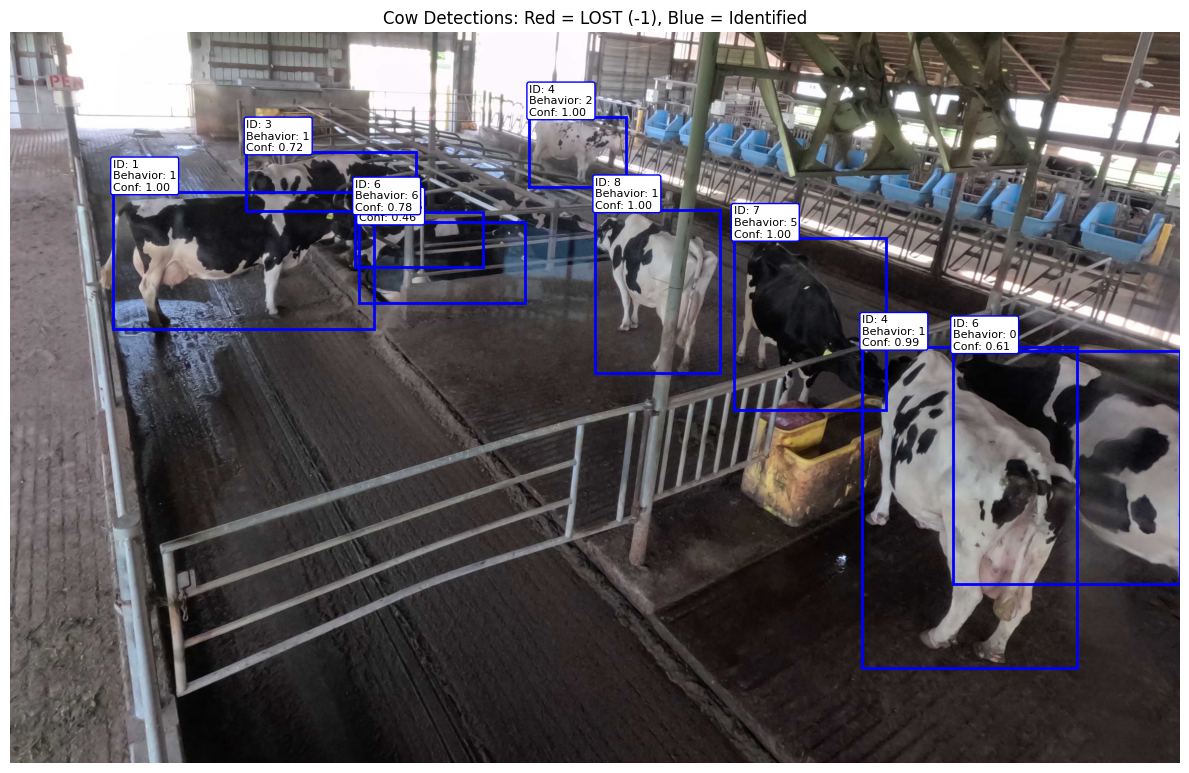

In [77]:
# 👉 Ejemplo de uso
image_path = "1690496397_17-19-57.jpg"
df_result, _, _ = process_image(image_path, yolo_model, behavior_model, id_model_lying, id_model_not_lying)
visualize_detections(image_path, df_result)

In [84]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

def draw_yolo_boxes(img_path, yolo_model, conf_threshold=0.3):
    """
    Draws YOLOv8 bounding boxes on the image (green + thick) and displays it.

    Args:
        img_path (str): Path to the input image.
        yolo_model: YOLOv8 model already loaded.
        conf_threshold (float): Minimum confidence score to draw a box.

    Returns:
        PIL.Image: Image with bounding boxes drawn.
    """
    img = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(img)

    try:
        font = ImageFont.truetype("arial.ttf", size=16)
    except:
        font = ImageFont.load_default()

    results = yolo_model(img_path)
    boxes = results[0].boxes

    for box in boxes:
        conf = box.conf[0].item()
        if conf < conf_threshold:
            continue

        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
        cls = int(box.cls[0].item())
        label = f"Class {cls} | {conf:.2f}"

        # Dibujar el rectángulo verde grueso
        draw.rectangle([x1, y1, x2, y2], outline="lime", width=5)

        # Opcional: Dibujar la etiqueta (puedes comentar esto si no la quieres)
        draw.text((x1 + 5, y1 + 5), label, fill="white", font=font)

    # Mostrar la imagen
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title("YOLO: Bounding Boxes", fontsize=14)
    plt.show()

    return img



image 1/1 /home/exouser/Downloads/1690496397_17-19-57.jpg: 416x640 9 cows, 9.8ms
Speed: 1.7ms preprocess, 9.8ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


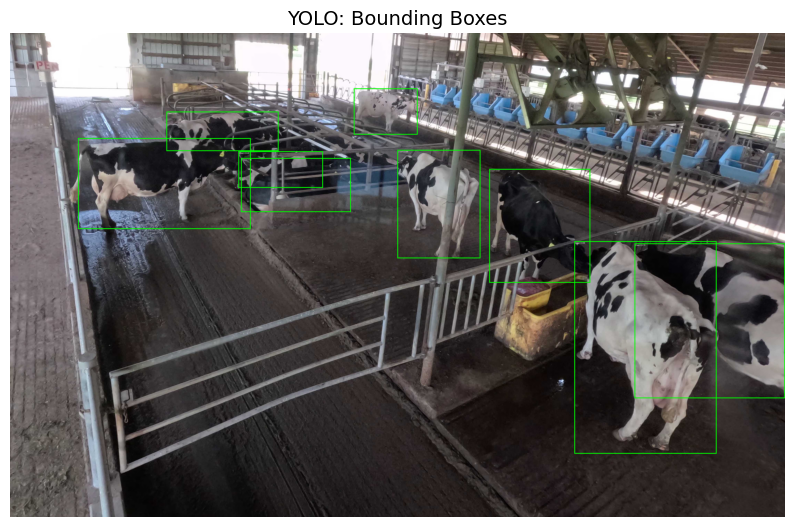

In [85]:

img_with_boxes = draw_yolo_boxes("1690496397_17-19-57.jpg", yolo_model)
